<a href="https://colab.research.google.com/github/vzinkovski/umich_siads_capstone/blob/main/forecast_sp500_returns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FORECASTING DAILY RETURNS FOR S&P 500 CONSTITUENTS & IMPLEMENTING A TRADING STRATEGY

*Authors: Takehisa Kanayama & Vladimir Zinkovski*

# Libraries

In [4]:
%%capture

# install missing libraries
!pip install fredapi
!pip install lightgbm
!pip install optuna
!pip install skorch
!pip install watermark

In [ ]:
%%capture
import os

# manually install technical analysis library
# due to compatibility issues with google colab
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar xvzf ta-lib-0.4.0-src.tar.gz
os.chdir('ta-lib')
!./configure --prefix=/usr
!make
!make install # wait ~ 30s
os.chdir('../')
!pip install TA-Lib

In [5]:
%%capture

# api libraries
import yfinance as yf
import fredapi as fa

# financial libraries
import talib

# machine learning libraries
import lightgbm as lgb
from lightgbm import LGBMClassifier
import optuna
from optuna.samplers import TPESampler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

# deep learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skorch.callbacks import EpochScoring
from skorch import NeuralNetClassifier

# standard libraries
import numpy as np
import pandas as pd
from scipy.stats import zscore

# visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve, precision_score

# utility
from datetime import datetime
import gc
import gdown
import pickle
import requests
from tqdm import tqdm
import warnings
from joblib import dump, load

In [ ]:
# pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 250)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))

# other display
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load data

## Define date range

In [13]:
# define date range for entire download
start_date = '2000-01-01'
end_date = '2023-12-31'

# define training and validation date ranges
end_train_date = '2017-12-31'
end_valid_date = '2020-12-31'

## Stock data

### Wikipedia: stock tickers

In [ ]:
# get list of sp500 tickers from wikipedia
sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500_tickers = sp500_tickers.Symbol.tolist()

In [ ]:
# in case above cell does not work, then load sp500 tickers from backup text file
sp500_tickers_url = 'https://github.com/vzinkovski/capstone/raw/main/sp500_tickers.txt'
response = requests.get(sp500_tickers_url)
sp500_tickers = response.text.splitlines()

### Yahoo! Finance: stock data

In [ ]:
# download ohlc price and volume data
yf_df = yf.download(sp500_tickers, start=start_date, end=end_date)

In [ ]:
# in case above cell does not work, then load sp500 data from backup parquet file
sp500_data_url = 'https://github.com/vzinkovski/capstone/raw/main/sp500_data.parquet'
yf_df = pd.read_parquet(sp500_data_url)

# reshape df from wide to long
yf_df = yf_df.stack().reset_index(level=1)

## Macroeconomic data

### Federal Reserve Economic Data

In [ ]:
# please note that this is a freely available API key
api_key = "a74d505e6731a2b5b06fdcf6ca20f6f5"
fred = fa.Fred(api_key = api_key)

In [ ]:
#get daily data

#select Fred data code to retrieve
daily = ['DFF', #Fed Fund Effective Rate, from 1954-07-01
         'DGS10', #10 year constant maturity US Treasury, from 1962-01-02
         ]

#create dictionary to rename columns
daily_columns = {'DFF':'FFE_Rate',
                 'DGS10':'10yr_UST'}

daily_df = pd.DataFrame()

for code in daily:
  series = fred.get_series(code)
  series_df = pd.DataFrame(series)
  series_df.columns = [code]
  daily_df = pd.merge(daily_df, series_df, left_index=True, right_index=True, how='outer') #how = outer to keep entire dates

daily_df = daily_df.rename(columns = daily_columns)
daily_df = daily_df.fillna(method='ffill')
daily_df = daily_df.shift(1) #creating 1 day lag to avoid data leakage (closing rate not available until the day closes)
daily_df = daily_df.loc['2000-01-01':'2023-12-31']

daily_df.tail()


,FFE_Rate,10yr_UST
2023-12-27,5.3300,3.8900
2023-12-28,5.3300,3.7900
2023-12-29,5.3300,3.8400
2023-12-30,5.3300,3.8800
2023-12-31,5.3300,3.8800


In [ ]:
def daily_conversion(df, start_date='2000-01-01', end_date='2023-12-31', fill_method = 'ffill'):
  new_dates = pd.date_range(start=start_date, end=end_date, freq='D')

  # Ensure new_dates is unique
  new_dates = pd.unique(new_dates)

  # Ensure df's index has no duplicates
  if df.index.duplicated().any():
    df = df[~df.index.duplicated(keep='first')]

  df_break = df.reindex(df.index.union(new_dates))
  df_break = df_break.fillna(method=fill_method)

  return df_break

In [ ]:
def get_monthly_data(fred_code, rename_dict):
  renamed = rename_dict[fred_code]

  df = fred.get_series_all_releases(fred_code)
  df = df[df['date']>'1999-01-01']
  df = df.drop_duplicates(subset='date', keep='first') #this removes revisions and avoid data leakage

  #break quarterly data to daily by forward fill
  df.set_index('realtime_start',inplace=True)
  df = daily_conversion(df)

  #%change shown only on the release day - to simplify, % change is calculated vs previous value without annualization
  df[f'{renamed}_%'] = df['value'].pct_change() *100

  #date filtered
  df = df.loc['2000-01-01':'2023-12-31']

  df = df[['value',f'{renamed}_%']]
  df = df.rename(columns = {'value':renamed})

  return df

In [ ]:
#get monthly data
#select Fred data code to retrieve
monthly = ['CPILFESL', #CPI for All Urban Consumers: All Items Less Food and Energy in U.S. City Ave., seasonally adjusted, Index 1982-1984=100, Jan 1957 to Apr 2023
         'PAYEMS', #All Employees, Total Nonfarm, seasonally adjusted, Unit #, Jan 1939 to May 2023
         'UNRATE', #Unemployment Rate, Unit %, Jan 1948 to May 2023
         'PCE', #Personal Consumption Expenditures. seasonally adjusted annual rate, unit = $bil, Jan 1959 to Apr 2023
         'INDPRO', #Industrial Production: Total Index, seasonally adjusted, Unite = Index 2017=100, Jan 1919 to Apr 2023
         ]

#create dictionary to rename columns
monthly_columns = {'CPILFESL':'CPI_Core',
                   'PAYEMS':'Nonfarm_Payroll',
                   'UNRATE':'Unemployment_Rate',
                   'PCE':'PCE',
                   'INDPRO':'Ind_Prod',
                   }

#monthly_df = get_fred_data(monthly, monthly_columns, start_date,end_date)

In [ ]:
monthly_df = pd.DataFrame()

for code in monthly:
  mo_data = get_monthly_data(code, monthly_columns)
  monthly_df = pd.merge(monthly_df, mo_data, left_index=True, right_index=True, how='outer') #how = outer to keep entire dates

#calculating moving averages for columns ending with "%"
cols_to_average = [col for col in monthly_df.columns if col.endswith("%")]
for col in cols_to_average:
    for window in [7, 30, 60, 90]:
        monthly_df[f'{col}_{window}d_ma'] = monthly_df[col].rolling(window=window, min_periods=1).mean()

monthly_df.tail()

,CPI_Core,CPI_Core_%,Nonfarm_Payroll,Nonfarm_Payroll_%,Unemployment_Rate,Unemployment_Rate_%,PCE,PCE_%,Ind_Prod,Ind_Prod_%,CPI_Core_%_7d_ma,CPI_Core_%_30d_ma,CPI_Core_%_60d_ma,CPI_Core_%_90d_ma,Nonfarm_Payroll_%_7d_ma,Nonfarm_Payroll_%_30d_ma,Nonfarm_Payroll_%_60d_ma,Nonfarm_Payroll_%_90d_ma,Unemployment_Rate_%_7d_ma,Unemployment_Rate_%_30d_ma,Unemployment_Rate_%_60d_ma,Unemployment_Rate_%_90d_ma,PCE_%_7d_ma,PCE_%_30d_ma,PCE_%_60d_ma,PCE_%_90d_ma,Ind_Prod_%_7d_ma,Ind_Prod_%_30d_ma,Ind_Prod_%_60d_ma,Ind_Prod_%_90d_ma
realtime_start,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-12-27,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,-0.0044,0.0010,0.0005,0.0194,0.0000,-0.0014,-0.0152,-0.0088
2023-12-28,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,-0.0044,0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088
2023-12-29,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,0.0000,0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088
2023-12-30,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,0.0000,-0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088
2023-12-31,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,0.0000,-0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088


In [ ]:
#get GDP data

gdp = fred.get_series_all_releases('GDP')
gdp = gdp[gdp['date']>='1999-01-01']

#dataset has many release date due to back date revisions. Keeping only first 3 monthly updates for simplification
gdp['date'] = pd.to_datetime(gdp['date'])
gdp['rank'] = gdp.groupby('date').cumcount() + 1
gdp = gdp[gdp['rank'] <= 3]
gdp = gdp.drop(columns=['rank'])
gdp = gdp.drop_duplicates(subset='realtime_start', keep='last') #when 2 releases on same day, keeping latest quarter data only
gdp.set_index('realtime_start',inplace=True)

#break quarterly data to daily by forward fill
new_dates = pd.date_range(start='1999-01-01', end='2023-12-31', freq='D')
gdp_break = gdp.reindex(gdp.index.union(new_dates))
gdp_break = gdp_break.fillna(method='ffill')

#%change shown only on the release day - to simplify, % change is calculated vs previous GDP value without annualization
gdp_break['GDP_%'] = gdp_break['value'].pct_change() *100

# Calculating moving averages for columns ending with "%"
cols_to_average = [col for col in gdp_break.columns if col.endswith("%")]
col_list = ['value','GDP_%']
for col in cols_to_average:
    for window in [7, 30, 60, 90]:
        gdp_break[f'{col}_{window}d_ma'] = gdp_break[col].rolling(window=window, min_periods=1).mean()
        col_list.append(f'{col}_{window}d_ma')

#date filtered
gdp_break = gdp_break.loc['2000-01-01':'2023-12-31']

gdp_break = gdp_break[col_list]
gdp_break = gdp_break.rename(columns = {'value':'GDP'})

gdp_break.tail()

,GDP,GDP_%,GDP_%_7d_ma,GDP_%_30d_ma,GDP_%_60d_ma,GDP_%_90d_ma
2023-12-27,27610.1280,0.0000,-0.0177,-0.0016,-0.0008,0.0225
2023-12-28,27610.1280,0.0000,0.0000,-0.0016,-0.0008,0.0225
2023-12-29,27610.1280,0.0000,0.0000,-0.0041,-0.0008,0.0225
2023-12-30,27610.1280,0.0000,0.0000,-0.0041,-0.0008,0.0225
2023-12-31,27610.1280,0.0000,0.0000,-0.0041,-0.0008,0.0225


In [ ]:
macro_df = pd.concat([daily_df, monthly_df, gdp_break], axis=1)
macro_df.tail()

,FFE_Rate,10yr_UST,CPI_Core,CPI_Core_%,Nonfarm_Payroll,Nonfarm_Payroll_%,Unemployment_Rate,Unemployment_Rate_%,PCE,PCE_%,Ind_Prod,Ind_Prod_%,CPI_Core_%_7d_ma,CPI_Core_%_30d_ma,CPI_Core_%_60d_ma,CPI_Core_%_90d_ma,Nonfarm_Payroll_%_7d_ma,Nonfarm_Payroll_%_30d_ma,Nonfarm_Payroll_%_60d_ma,Nonfarm_Payroll_%_90d_ma,Unemployment_Rate_%_7d_ma,Unemployment_Rate_%_30d_ma,Unemployment_Rate_%_60d_ma,Unemployment_Rate_%_90d_ma,PCE_%_7d_ma,PCE_%_30d_ma,PCE_%_60d_ma,PCE_%_90d_ma,Ind_Prod_%_7d_ma,Ind_Prod_%_30d_ma,Ind_Prod_%_60d_ma,Ind_Prod_%_90d_ma,GDP,GDP_%,GDP_%_7d_ma,GDP_%_30d_ma,GDP_%_60d_ma,GDP_%_90d_ma
2023-12-27,5.3300,3.8900,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,-0.0044,0.0010,0.0005,0.0194,0.0000,-0.0014,-0.0152,-0.0088,27610.1280,0.0000,-0.0177,-0.0016,-0.0008,0.0225
2023-12-28,5.3300,3.7900,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,-0.0044,0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088,27610.1280,0.0000,0.0000,-0.0016,-0.0008,0.0225
2023-12-29,5.3300,3.8400,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,0.0000,0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088,27610.1280,0.0000,0.0000,-0.0041,-0.0008,0.0225
2023-12-30,5.3300,3.8800,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,0.0000,-0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088,27610.1280,0.0000,0.0000,-0.0041,-0.0008,0.0225
2023-12-31,5.3300,3.8800,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,0.0000,-0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088,27610.1280,0.0000,0.0000,-0.0041,-0.0008,0.0225


In [ ]:
# the unit of each economic data is different
# Adding standardized columns with "_st" suffix for columns without "%"

#cols_to_standardize = [col for col in macro_df.columns if not col.endswith("%") and not col.endswith("ma")]
#scaler = StandardScaler()
#for col in cols_to_standardize:
#    macro_df[f'{col}_st'] = scaler.fit_transform(macro_df[[col]])

#macro_df.tail()

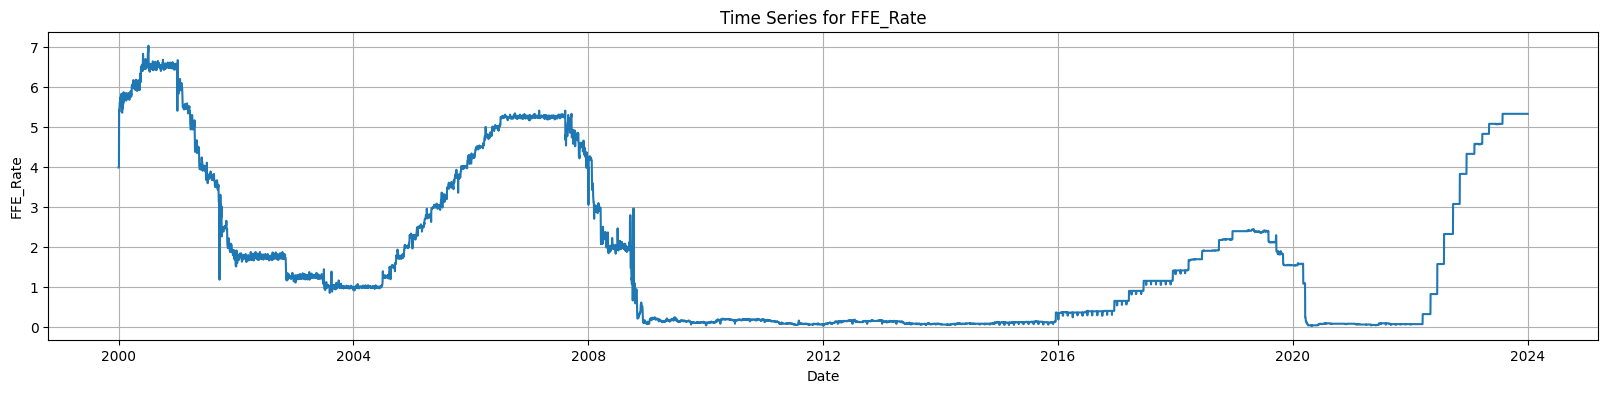

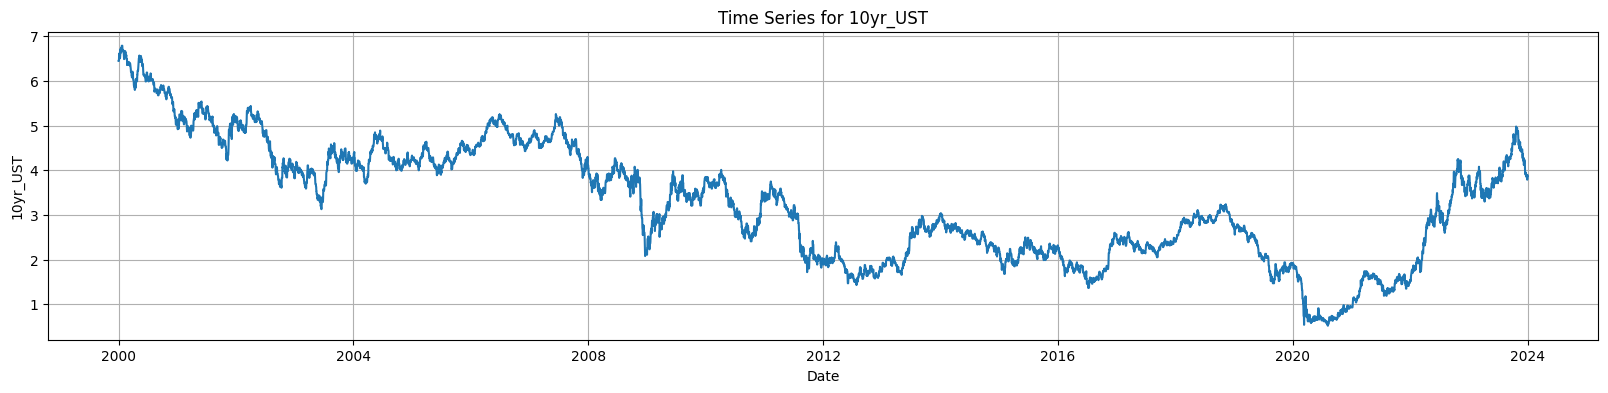

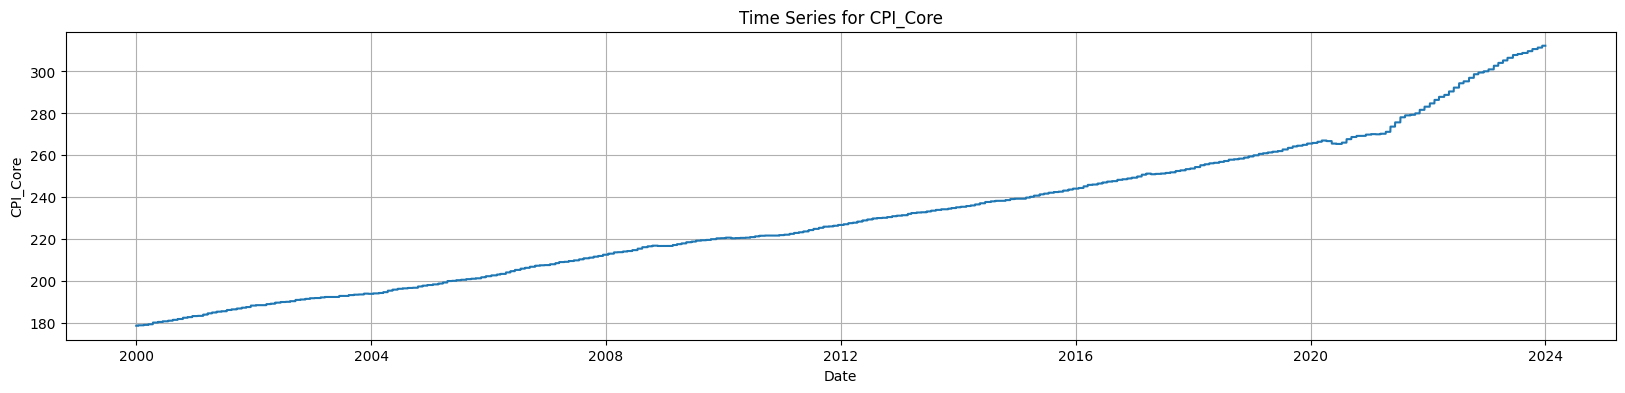

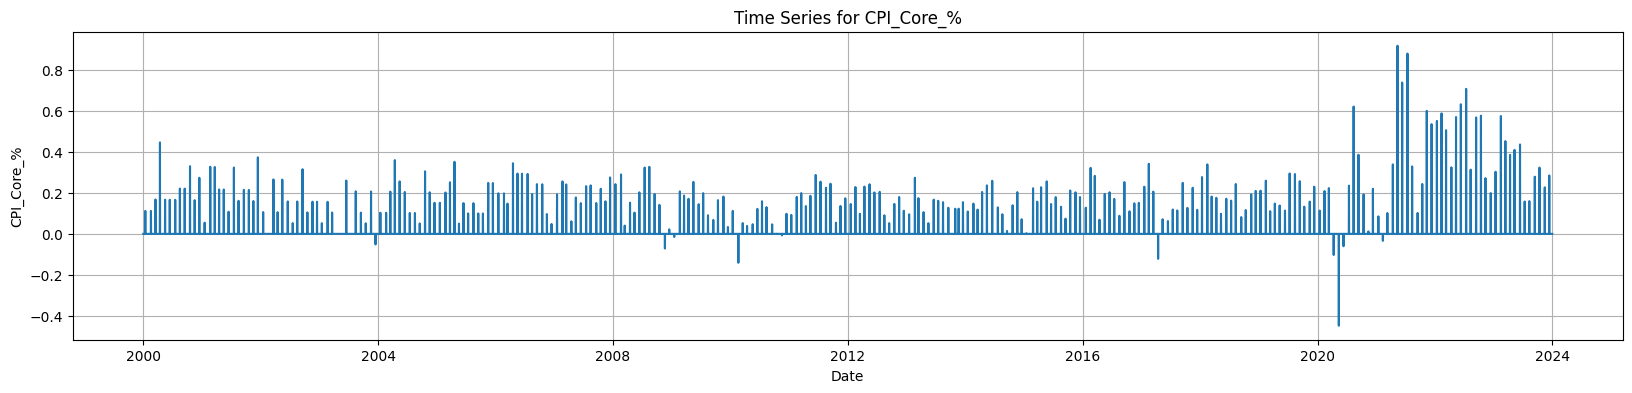

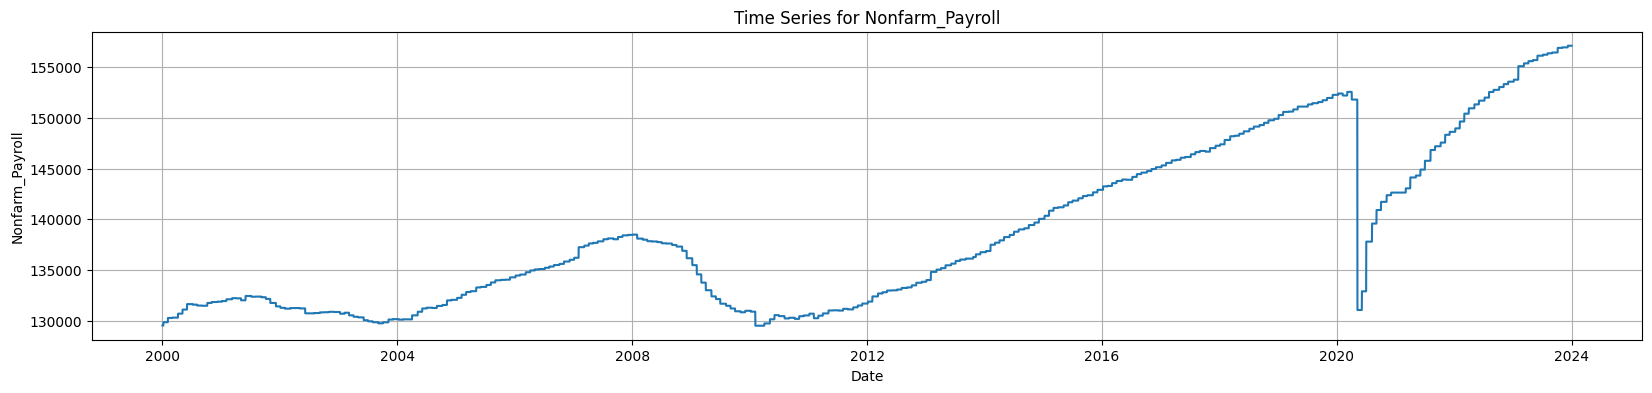

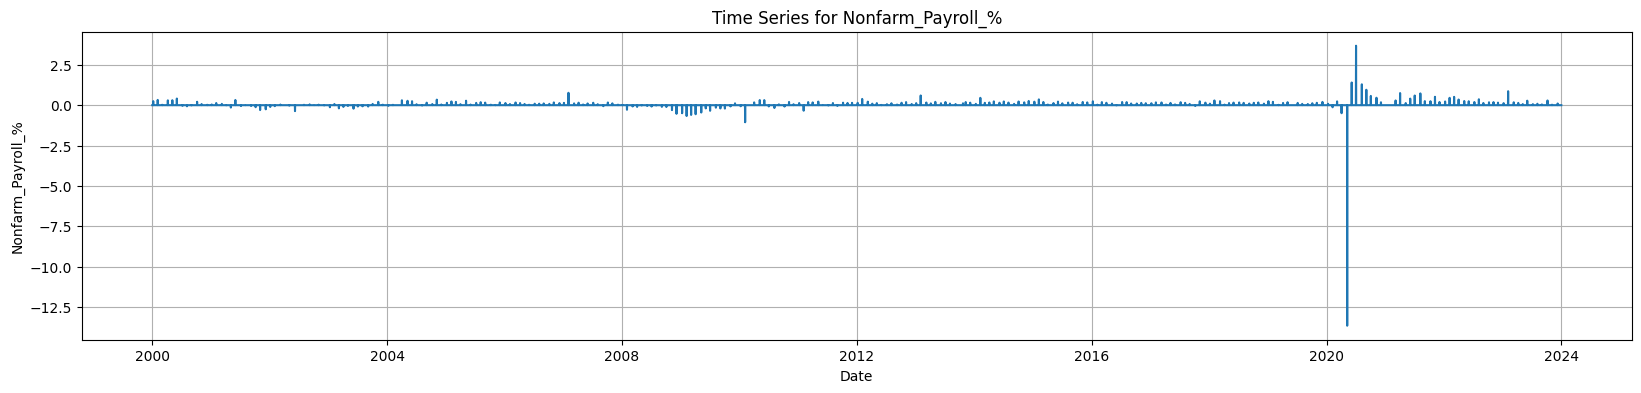

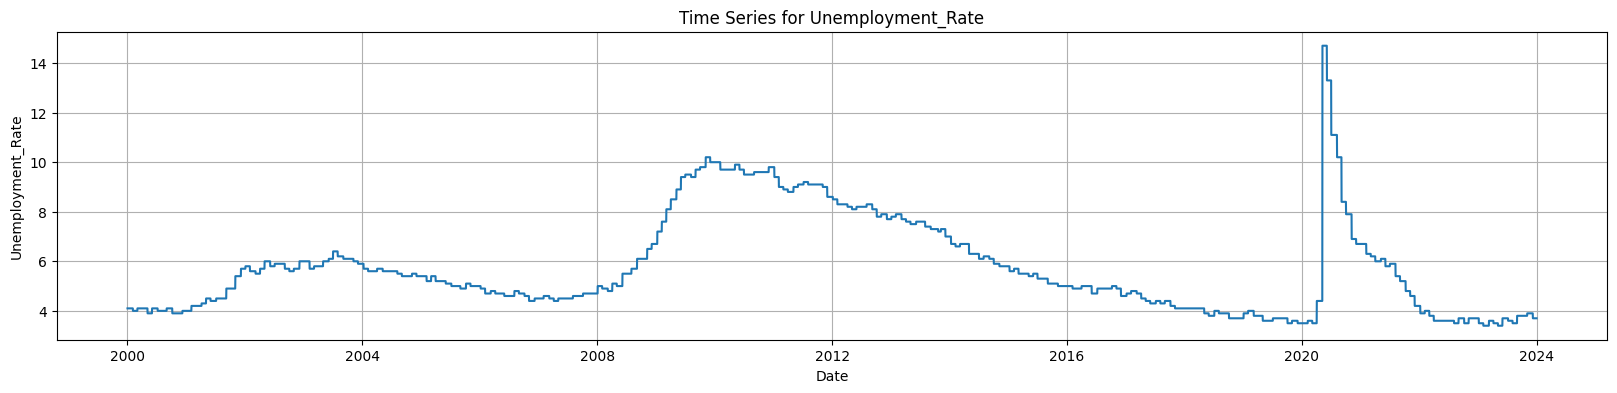

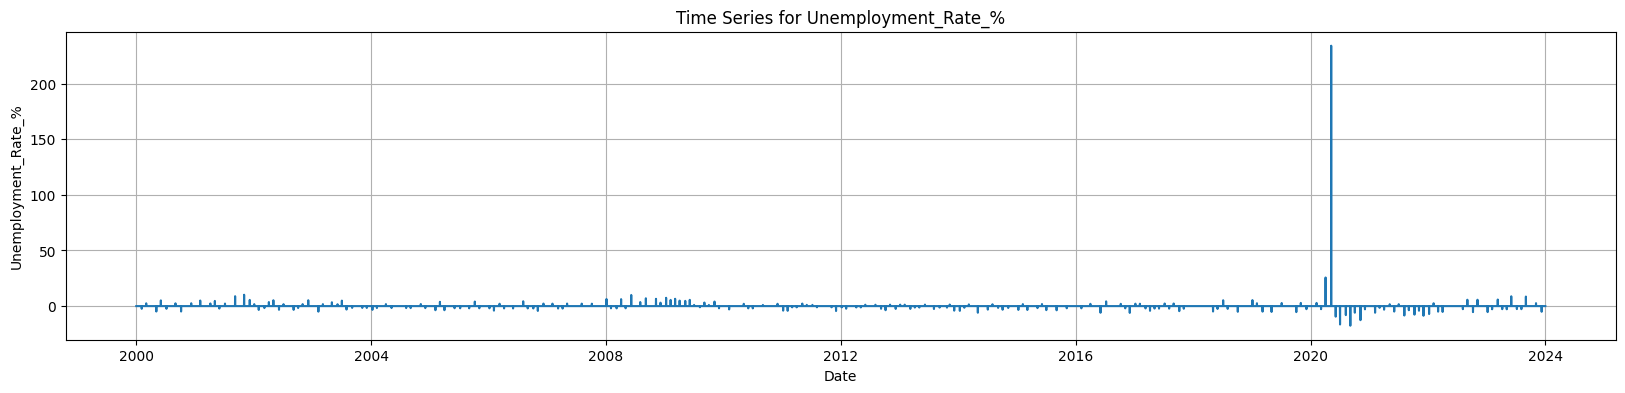

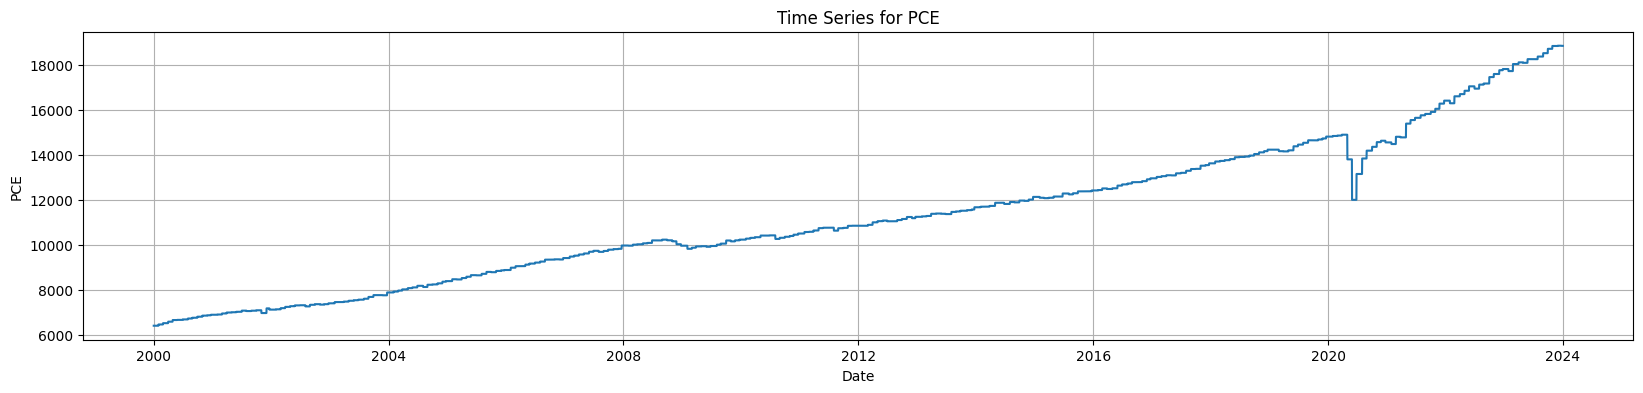

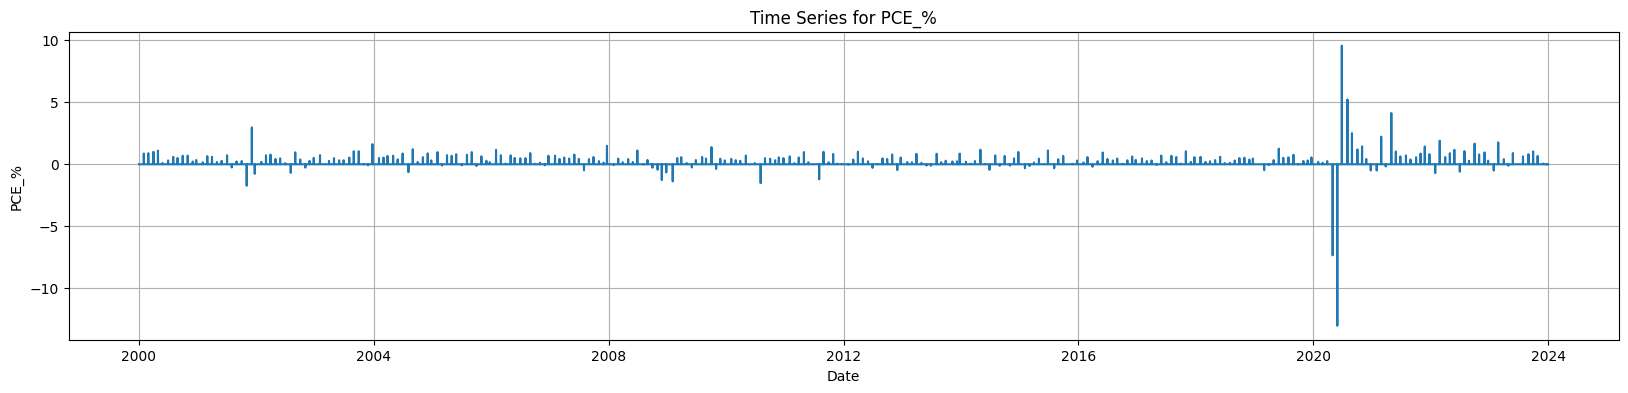

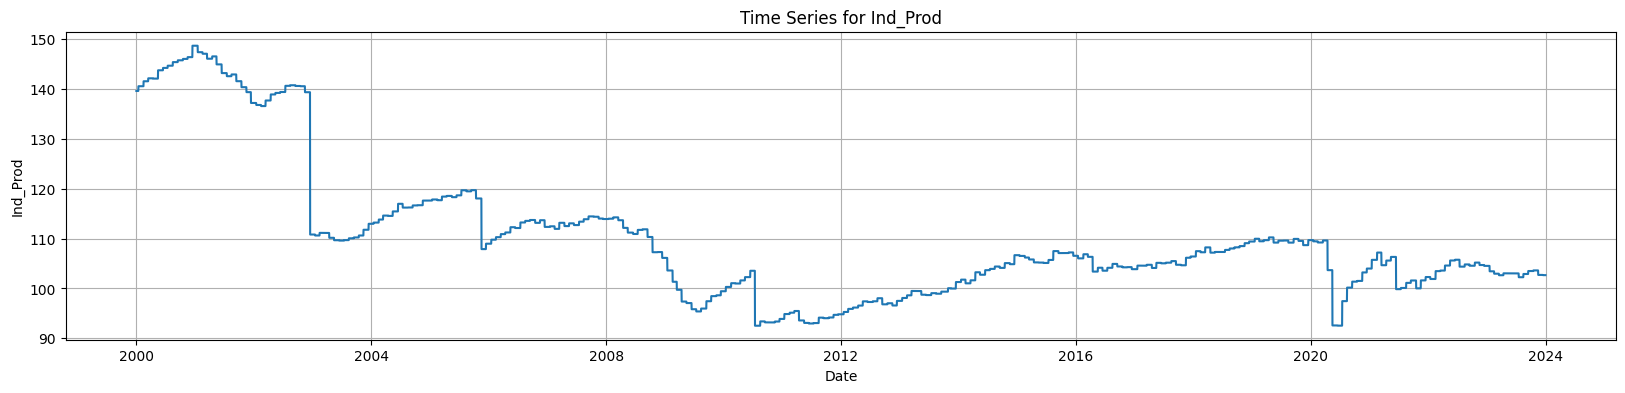

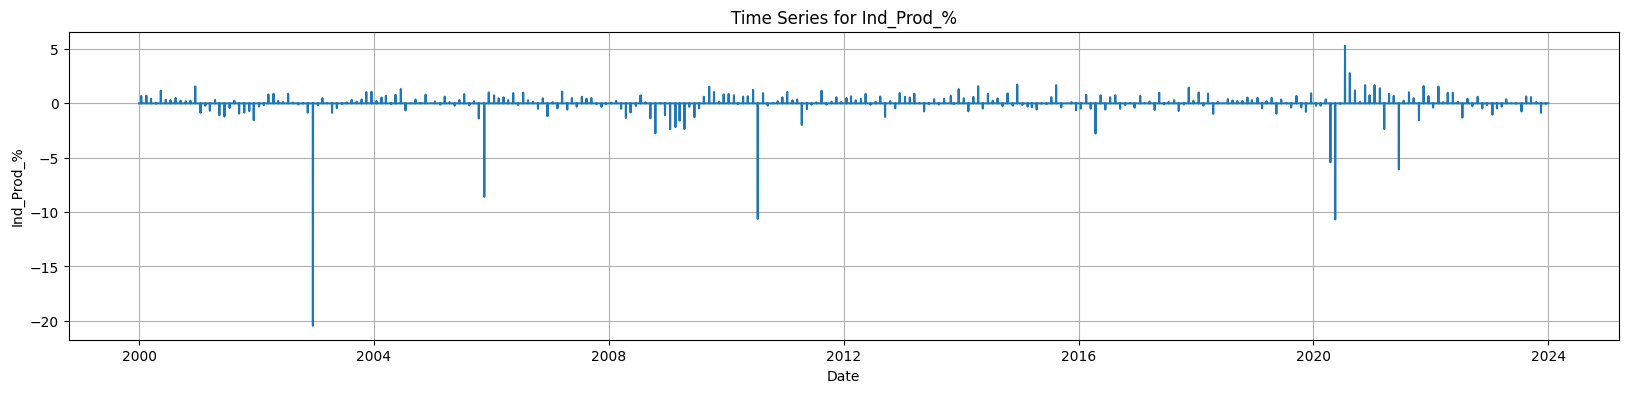

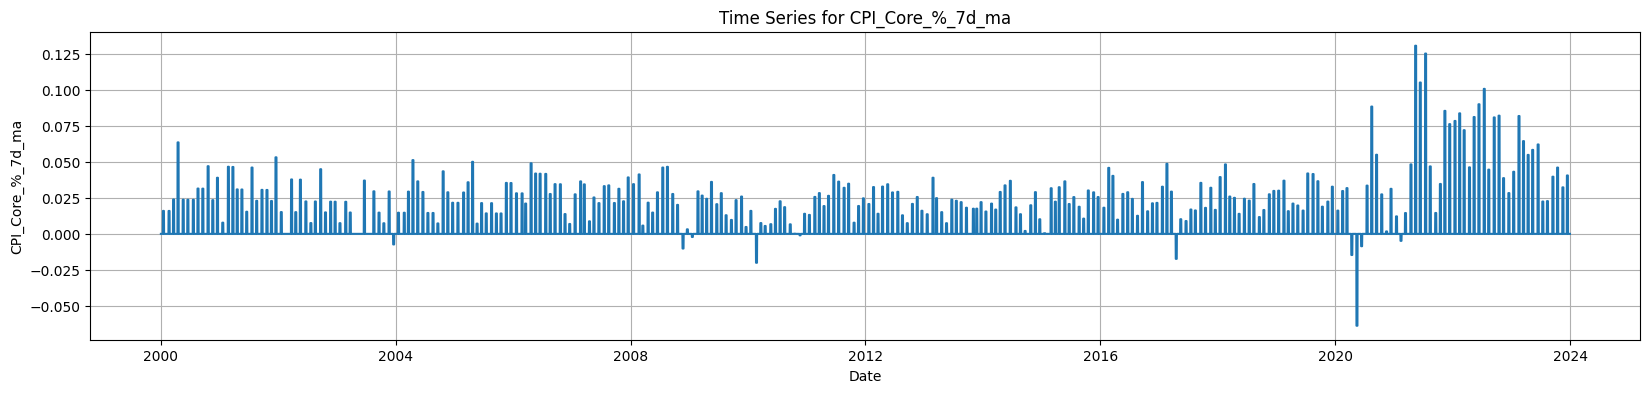

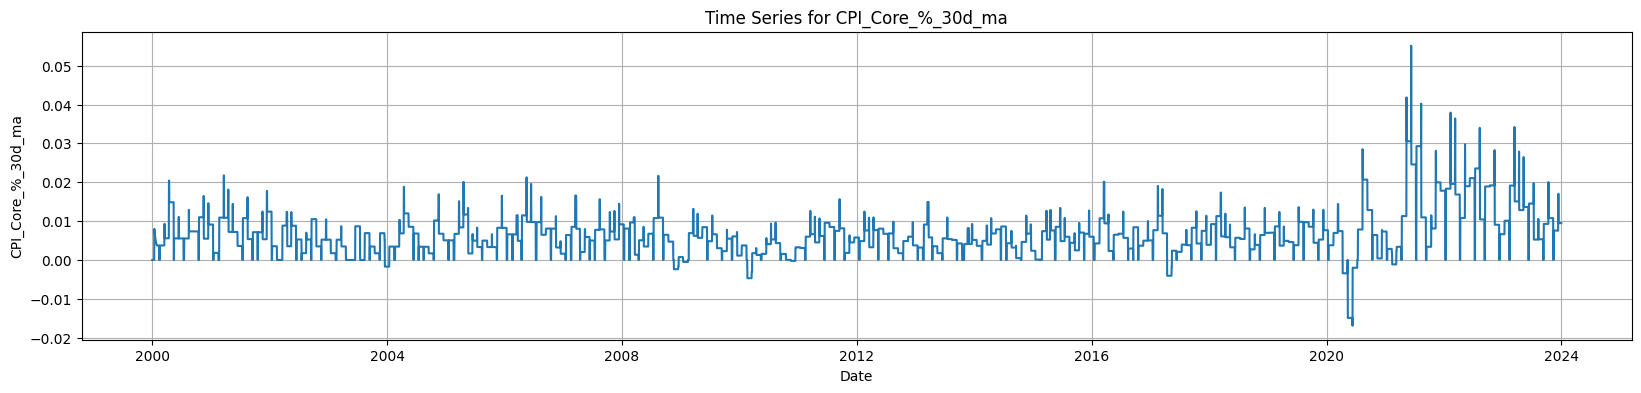

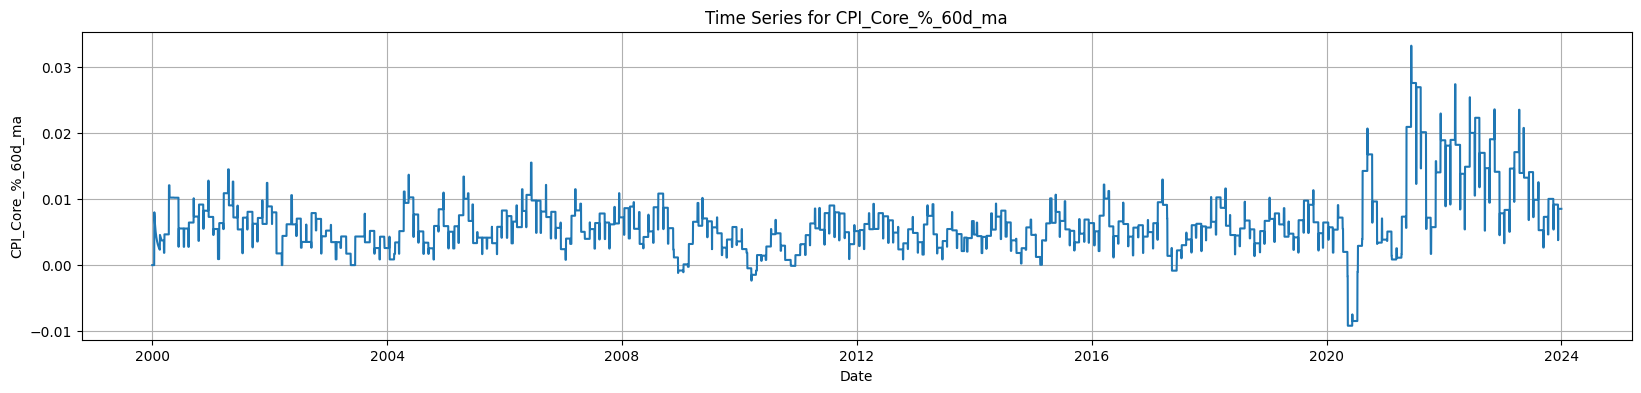

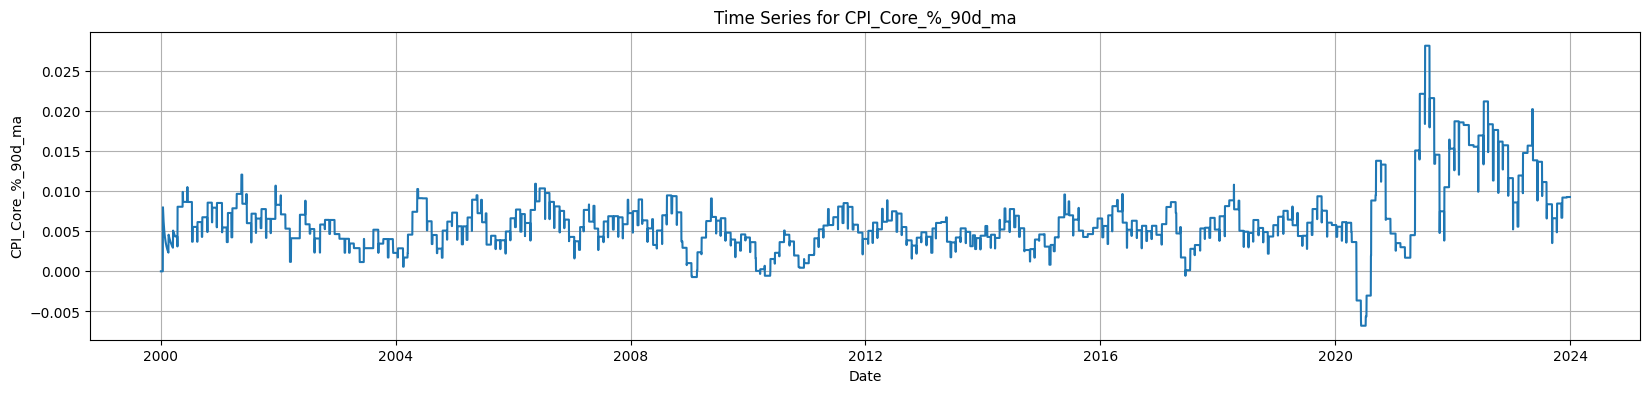

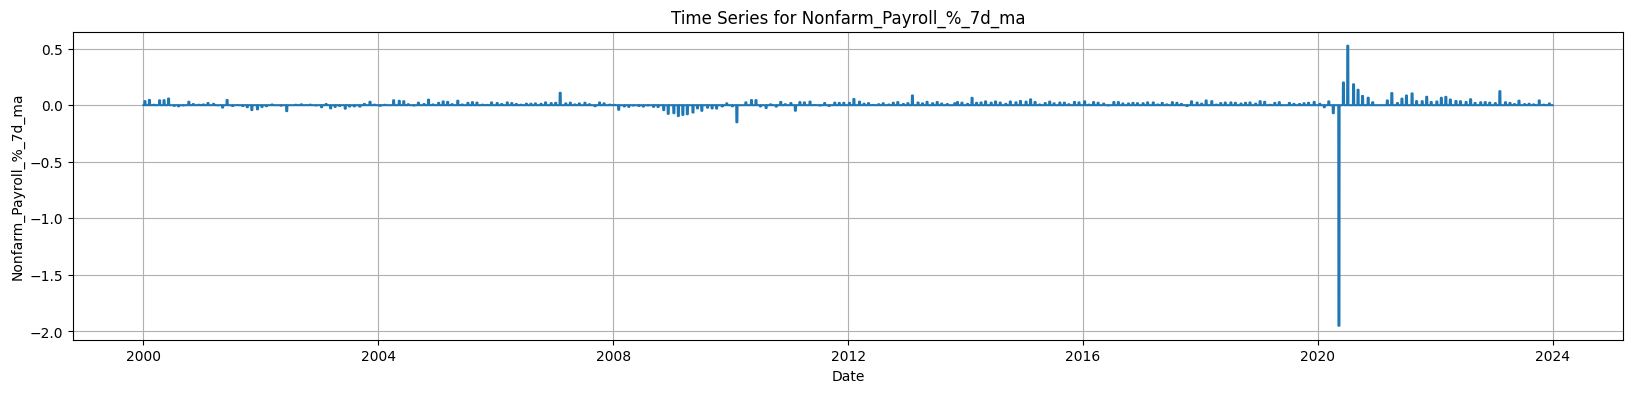

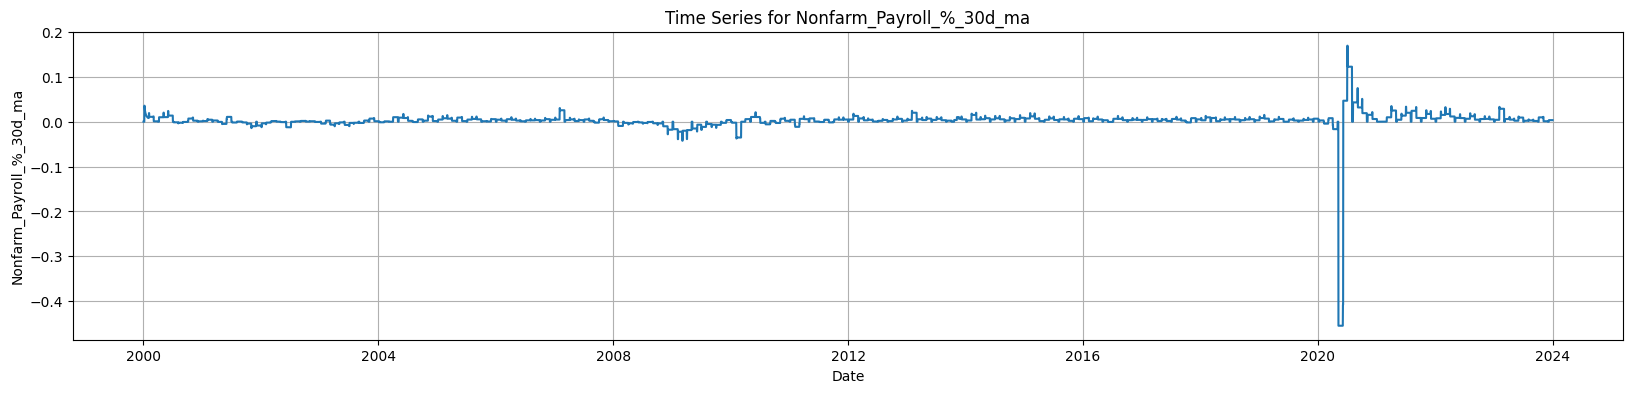

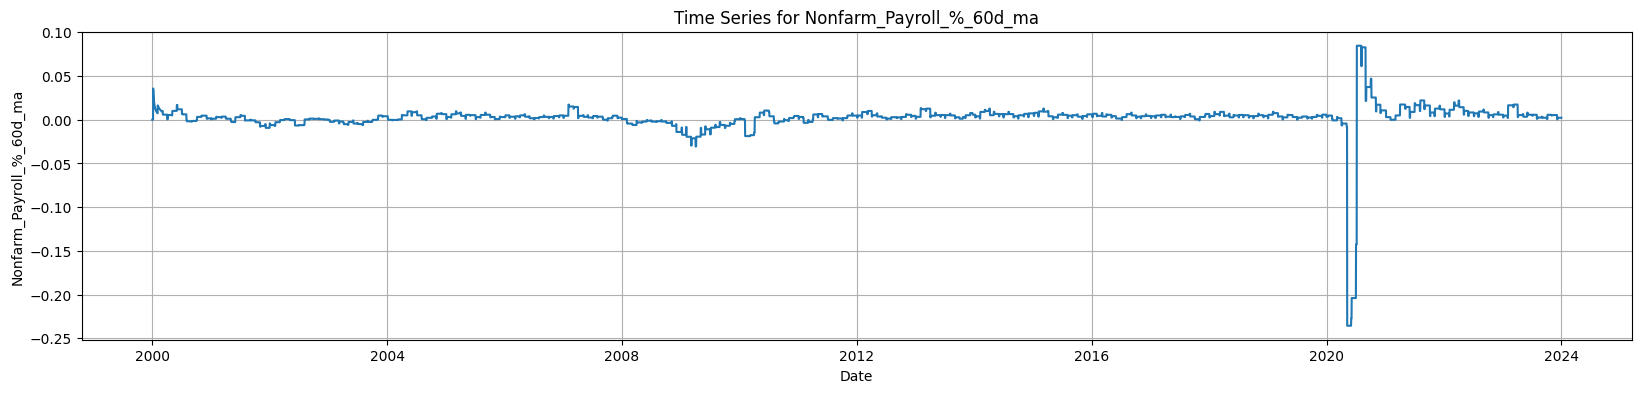

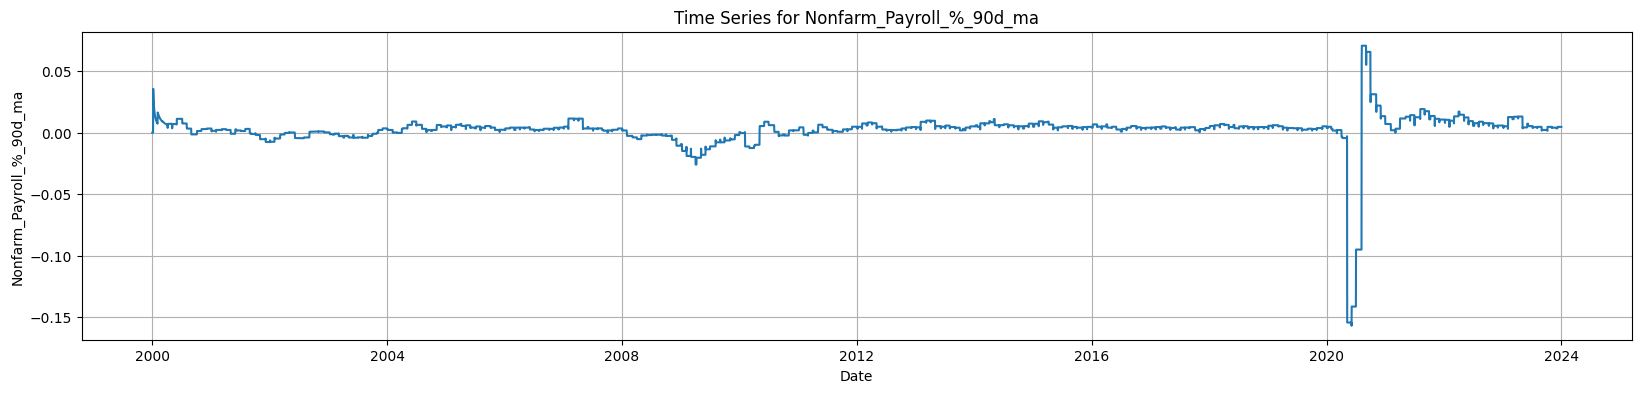

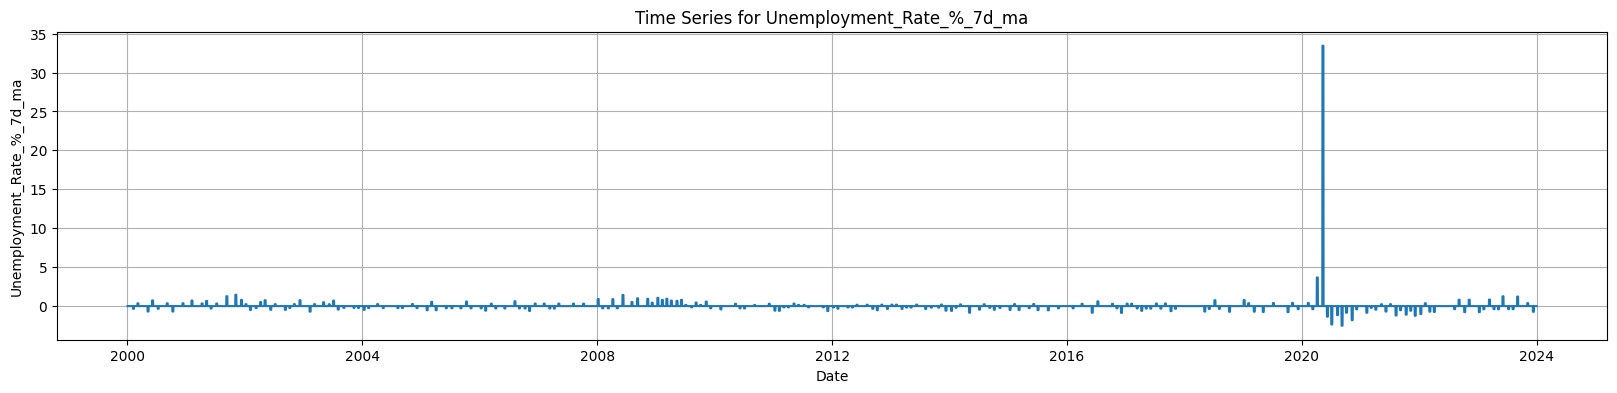

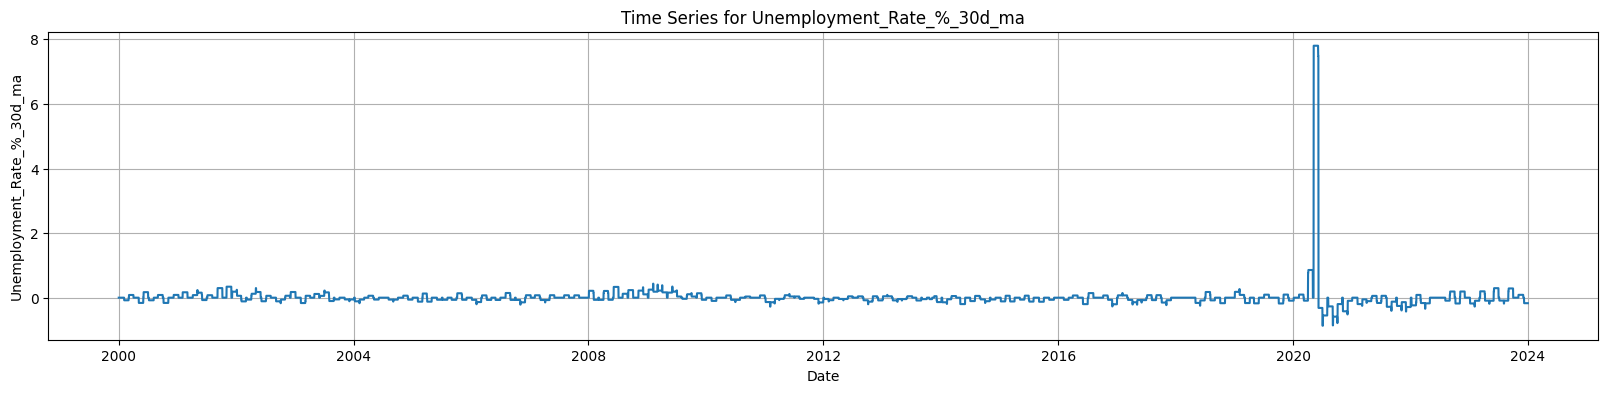

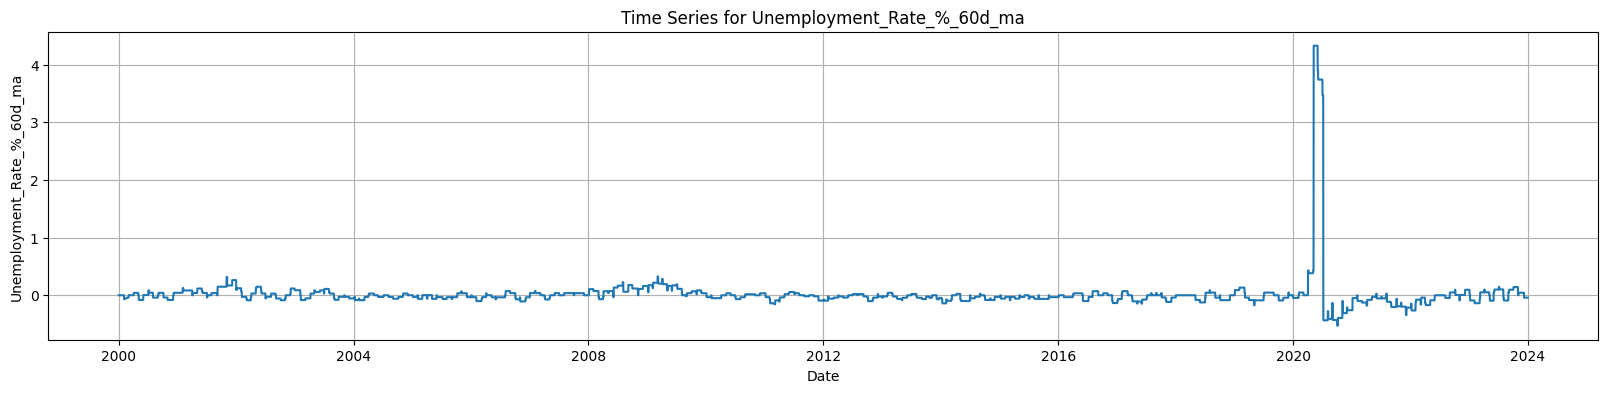

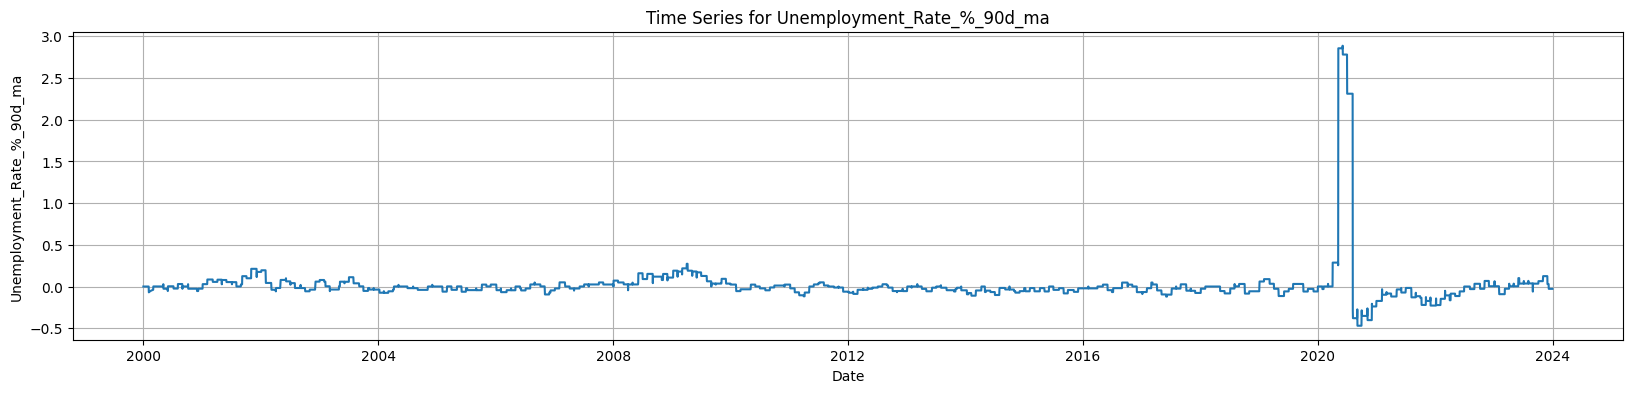

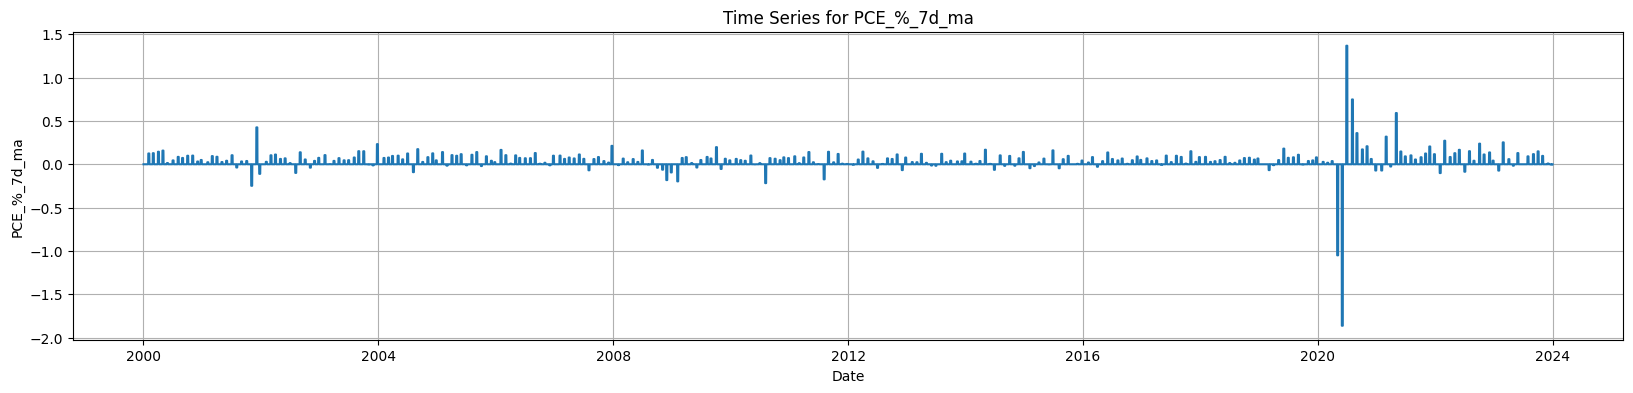

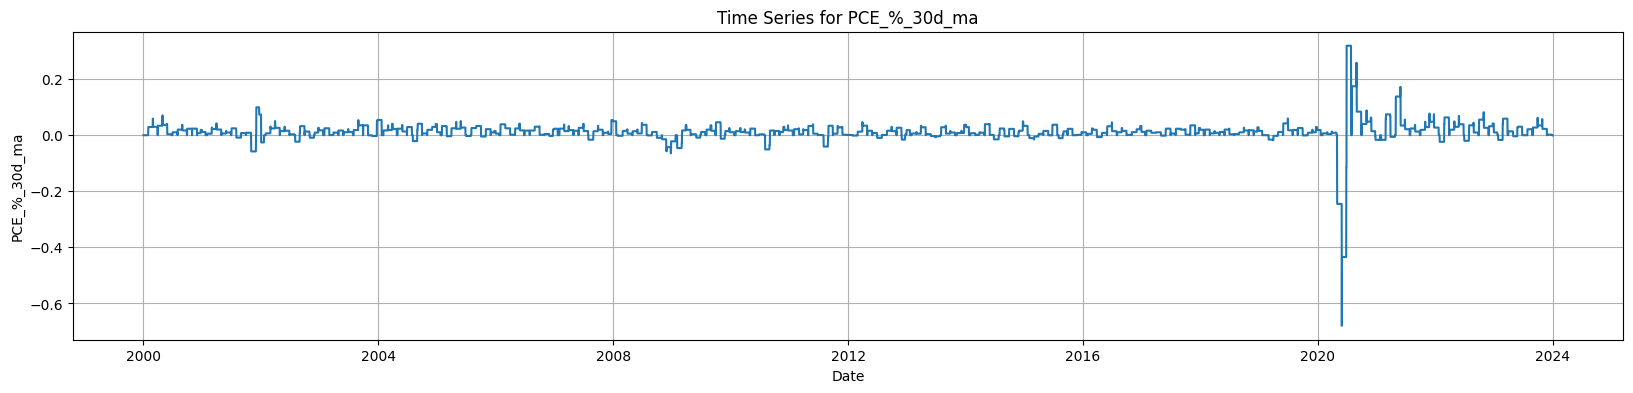

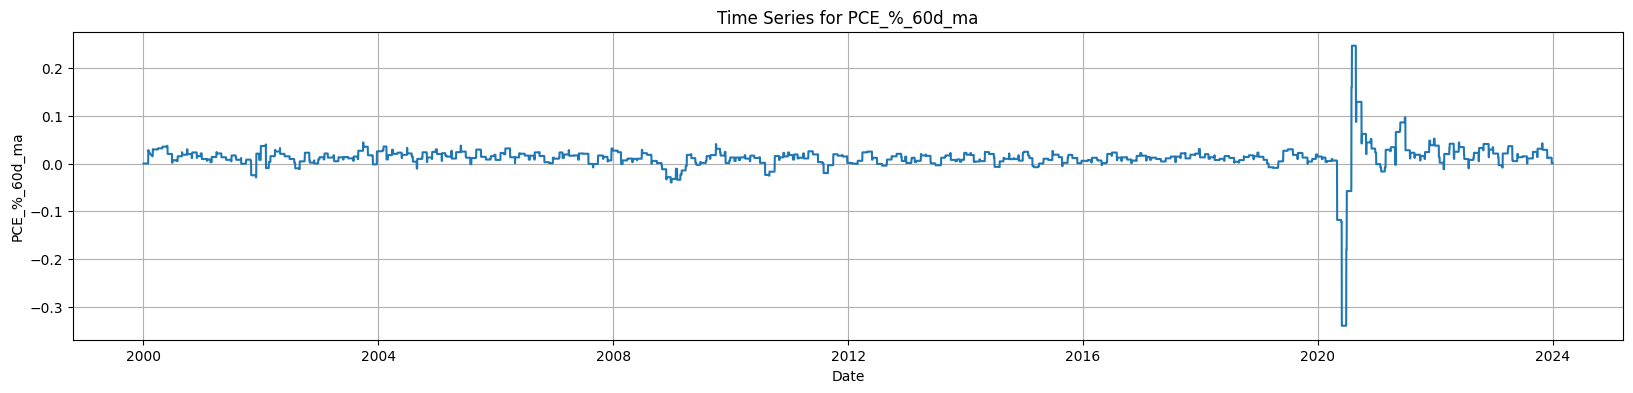

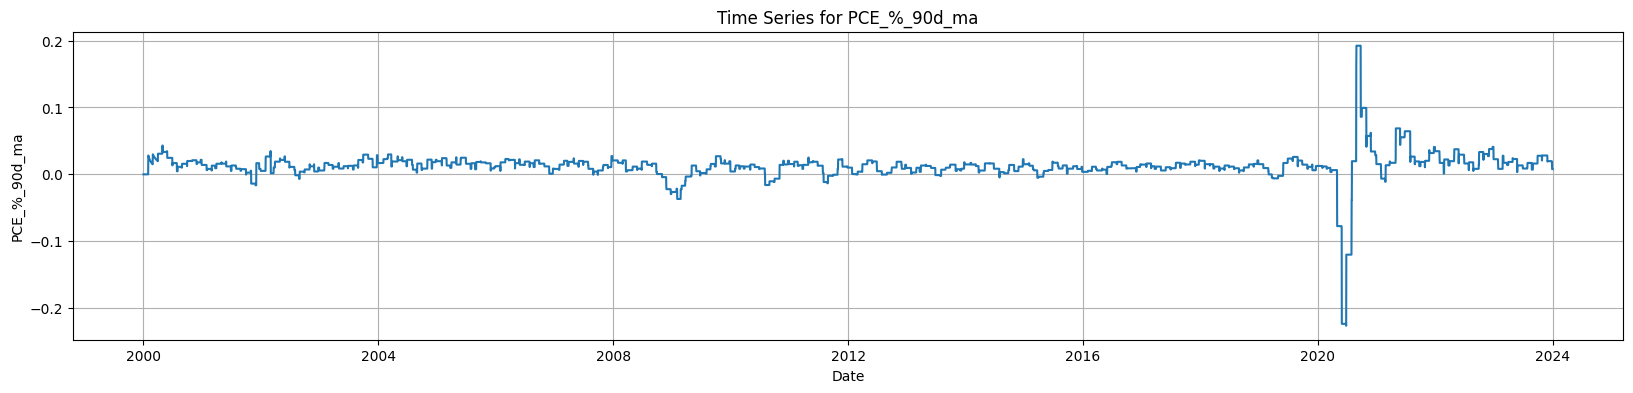

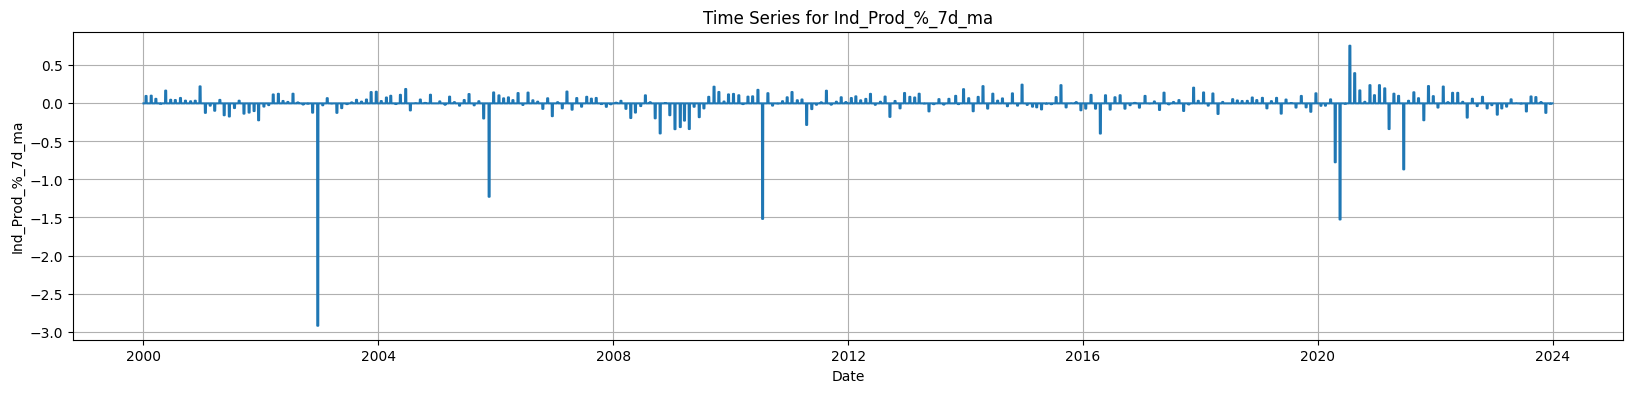

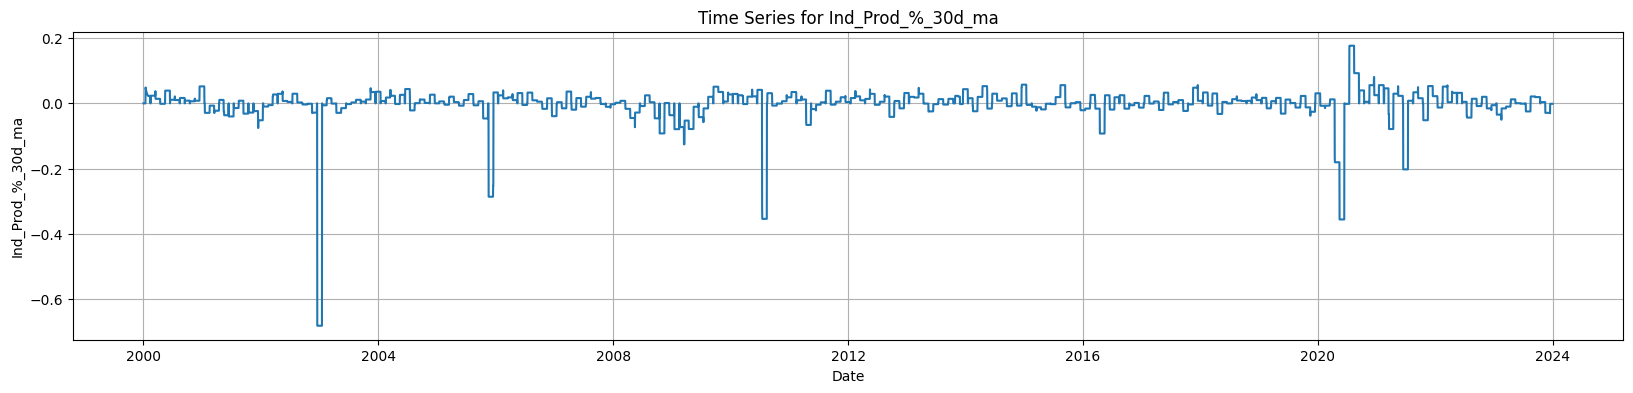

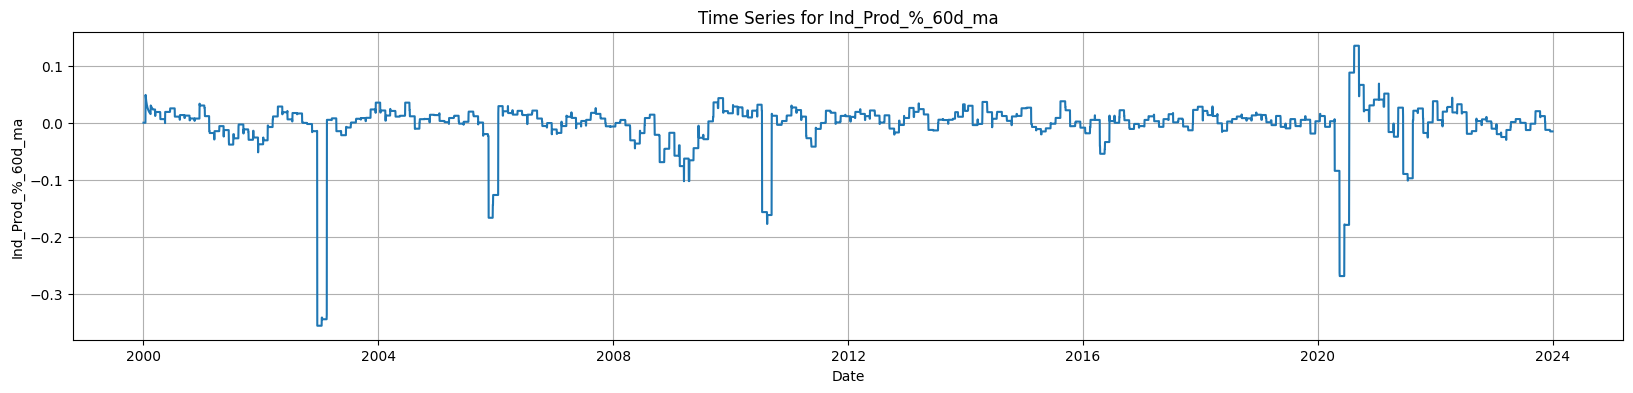

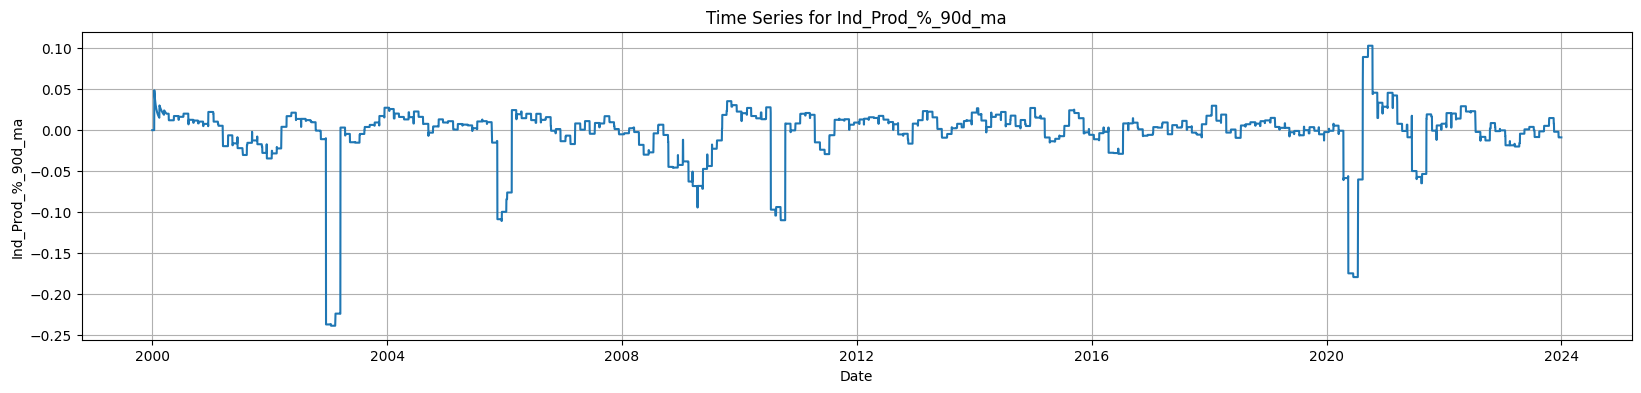

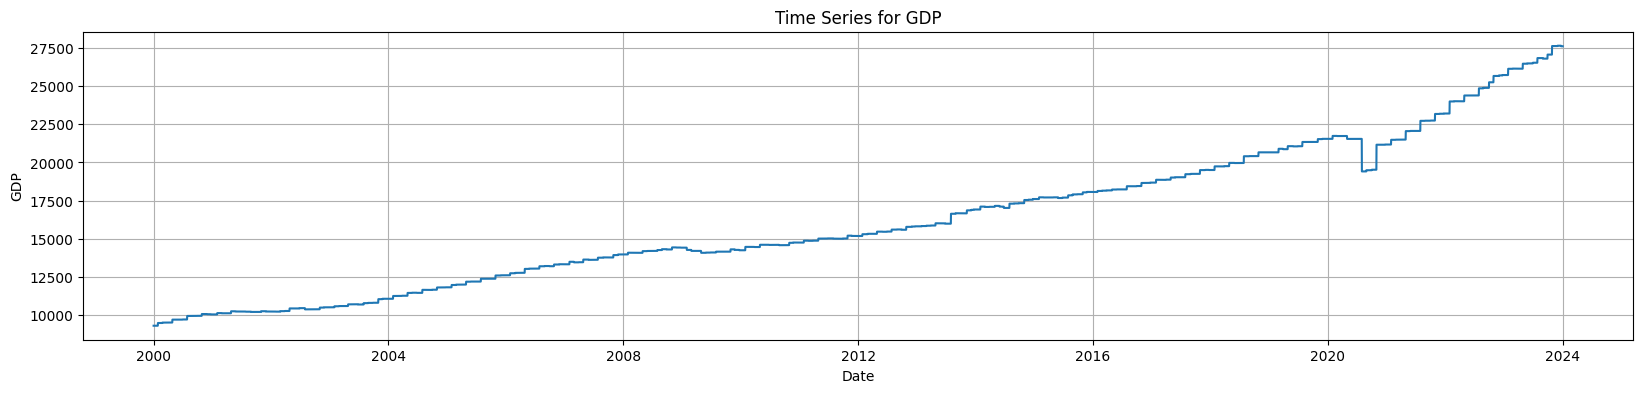

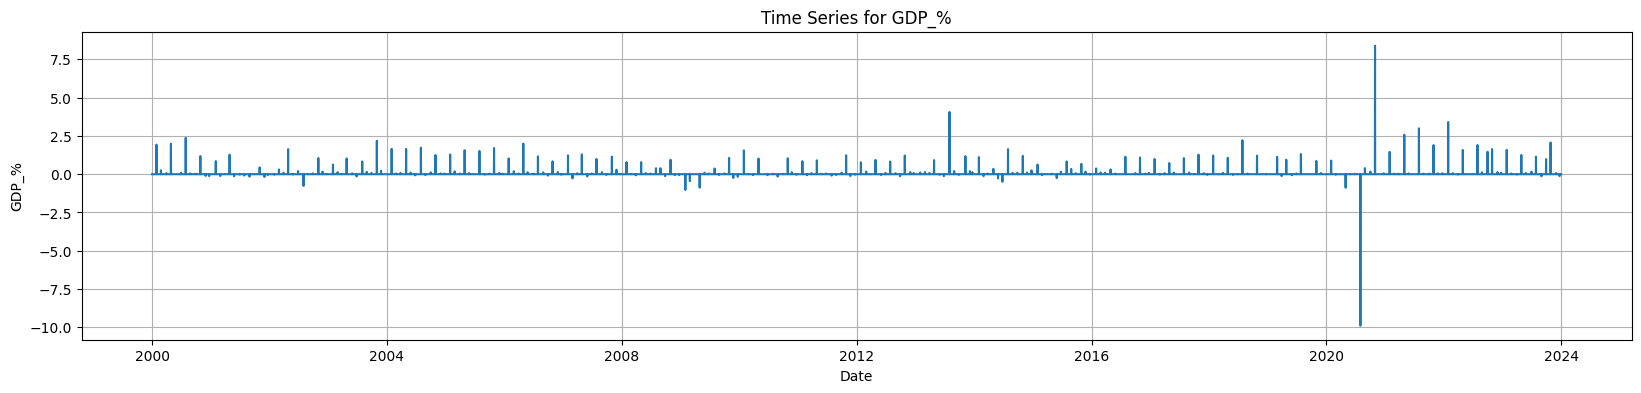

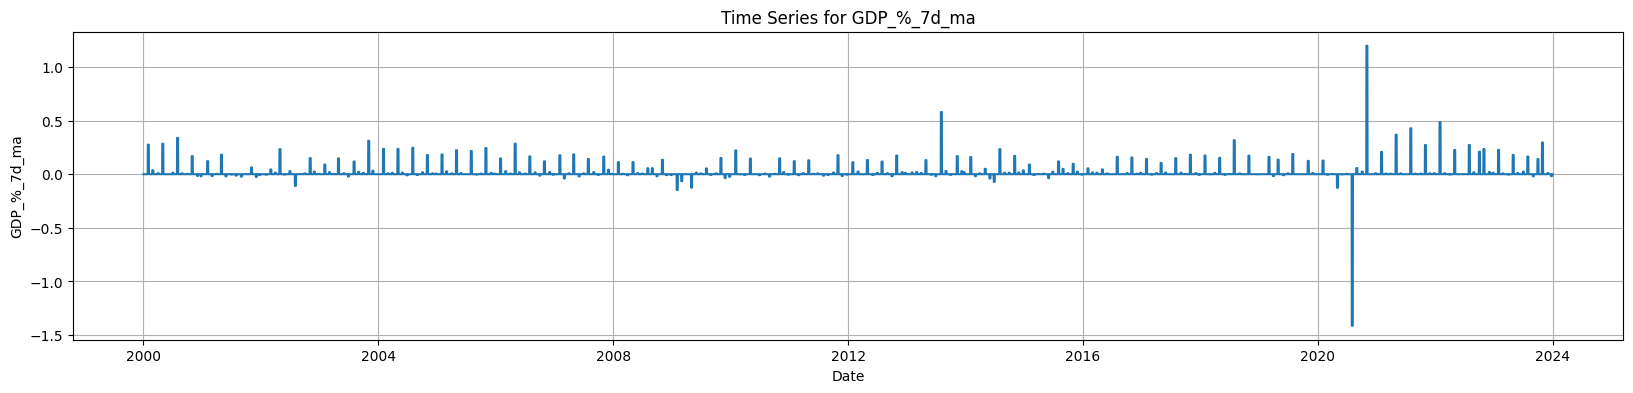

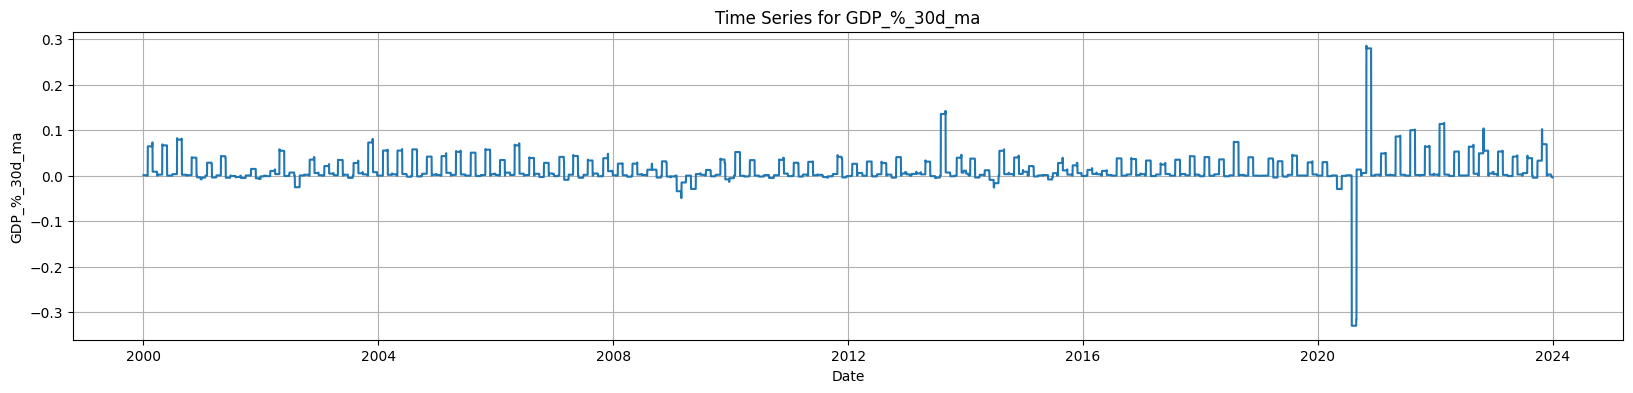

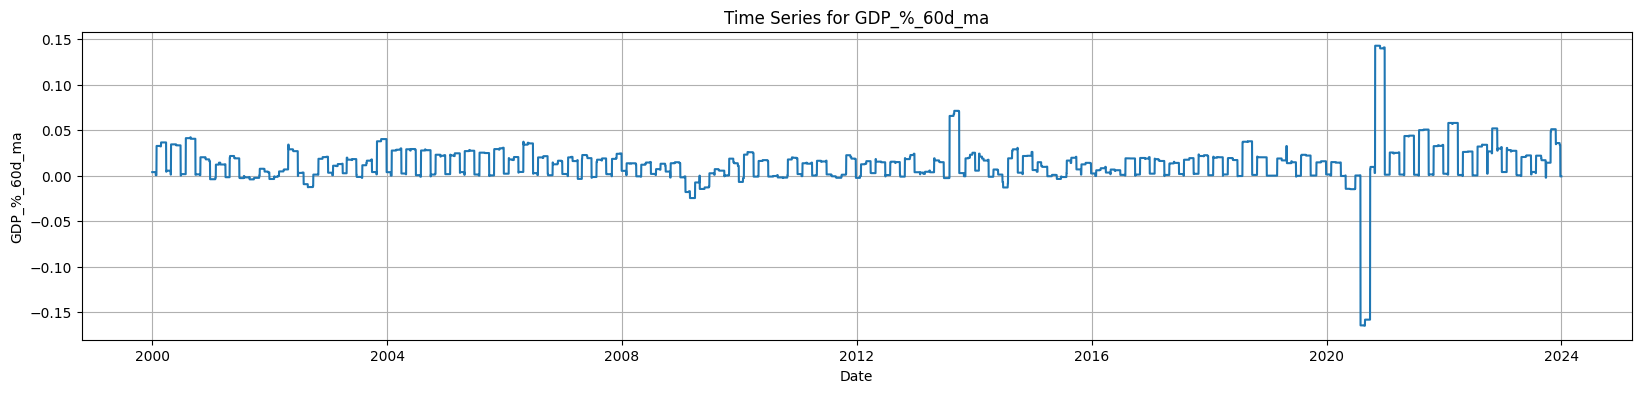

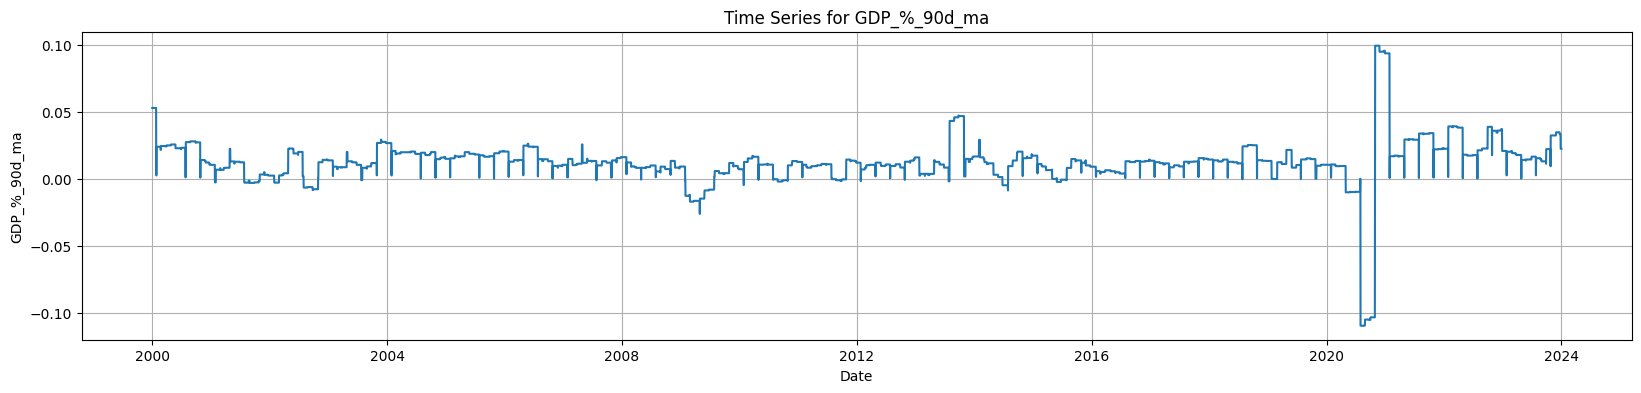

In [ ]:
for col in macro_df.columns:
    plt.figure(figsize=(20, 4))
    plt.plot(macro_df.index, macro_df[col], linestyle='-')
    plt.title(f'Time Series for {col}')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.grid(True)
    plt.show()

# Join data

In [ ]:
# Convert indices to columns
yf_df.reset_index(inplace=True)
macro_df.reset_index(inplace=True)

# Rename macro_df_reset index column to Date to merge with yf_df
macro_df.rename(columns={'index':'Date'},inplace=True)

# Merge the DataFrames on the 'Date' column
main_df = pd.merge(yf_df, macro_df, on='Date', how='left')

# Set 'Date' back as the index
main_df.set_index('Date', inplace=True)

main_df.tail()

,Ticker,Adj Close,Close,High,Low,Open,Volume,FFE_Rate,10yr_UST,CPI_Core,CPI_Core_%,Nonfarm_Payroll,Nonfarm_Payroll_%,Unemployment_Rate,Unemployment_Rate_%,PCE,PCE_%,Ind_Prod,Ind_Prod_%,CPI_Core_%_7d_ma,CPI_Core_%_30d_ma,CPI_Core_%_60d_ma,CPI_Core_%_90d_ma,Nonfarm_Payroll_%_7d_ma,Nonfarm_Payroll_%_30d_ma,Nonfarm_Payroll_%_60d_ma,Nonfarm_Payroll_%_90d_ma,Unemployment_Rate_%_7d_ma,Unemployment_Rate_%_30d_ma,Unemployment_Rate_%_60d_ma,Unemployment_Rate_%_90d_ma,PCE_%_7d_ma,PCE_%_30d_ma,PCE_%_60d_ma,PCE_%_90d_ma,Ind_Prod_%_7d_ma,Ind_Prod_%_30d_ma,Ind_Prod_%_60d_ma,Ind_Prod_%_90d_ma,GDP,GDP_%,GDP_%_7d_ma,GDP_%_30d_ma,GDP_%_60d_ma,GDP_%_90d_ma
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-12-29,YUM,130.0094,130.6600,131.2500,130.2100,130.4100,1196800.0000,5.3300,3.8400,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,0.0000,0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088,27610.1280,0.0000,0.0000,-0.0041,-0.0008,0.0225
2023-12-29,ZBH,121.7000,121.7000,122.4000,121.2400,121.4600,849600.0000,5.3300,3.8400,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,0.0000,0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088,27610.1280,0.0000,0.0000,-0.0041,-0.0008,0.0225
2023-12-29,ZBRA,273.3300,273.3300,276.3100,272.7700,274.7300,251300.0000,5.3300,3.8400,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,0.0000,0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088,27610.1280,0.0000,0.0000,-0.0041,-0.0008,0.0225
2023-12-29,ZION,43.4128,43.8700,44.6500,43.7200,44.6500,1420600.0000,5.3300,3.8400,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,0.0000,0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088,27610.1280,0.0000,0.0000,-0.0041,-0.0008,0.0225
2023-12-29,ZTS,196.9234,197.3700,198.0100,196.2500,196.6800,1007200.0000,5.3300,3.8400,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,0.0000,0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088,27610.1280,0.0000,0.0000,-0.0041,-0.0008,0.0225


# Preprocessing

## Downcast to optimise memory footprint

In [ ]:
# memory usage
memory = main_df.memory_usage(deep=True).sum() / (1024**2)
print(f"""
    Memory usage of the DataFrame
    - - -
    MB: {memory:.2f}
    GB: {memory/1024:.2f}
""")


    Memory usage of the DataFrame
    - - -
    MB: 474.57
    GB: 0.46



In [7]:
def downcast(df):

    # downcast float64 to float32
    float64_cols = df.select_dtypes(include=['float64']).columns
    df[float64_cols] = df[float64_cols].astype('float32')

    # downcast int64 to float32
    float64_cols = df.select_dtypes(include=['int64']).columns
    df[float64_cols] = df[float64_cols].astype('float32')

    return df

In [ ]:
main_df = downcast(main_df)

In [ ]:
# memory usage
memory = main_df.memory_usage(deep=True).sum() / (1024**2)
print(f"""
    Memory usage of the DataFrame
    - - -
    MB: {memory:.2f}
    GB: {memory/1024:.2f}
""")


    Memory usage of the DataFrame
    - - -
    MB: 627.17
    GB: 0.61



## Check missing values and outliers

In [ ]:
# check missing values
main_df.isna().sum()

Ticker                        0
Adj Close                     0
Close                         0
High                          0
Low                           0
Open                          0
Volume                        0
FFE_Rate                      0
10yr_UST                      0
CPI_Core                      0
CPI_Core_%                    0
Nonfarm_Payroll               0
Nonfarm_Payroll_%             0
Unemployment_Rate             0
Unemployment_Rate_%           0
PCE                           0
PCE_%                         0
Ind_Prod                      0
Ind_Prod_%                    0
CPI_Core_%_7d_ma              0
CPI_Core_%_30d_ma             0
CPI_Core_%_60d_ma             0
CPI_Core_%_90d_ma             0
Nonfarm_Payroll_%_7d_ma       0
Nonfarm_Payroll_%_30d_ma      0
Nonfarm_Payroll_%_60d_ma      0
Nonfarm_Payroll_%_90d_ma      0
Unemployment_Rate_%_7d_ma     0
Unemployment_Rate_%_30d_ma    0
Unemployment_Rate_%_60d_ma    0
Unemployment_Rate_%_90d_ma    0
PCE_%_7d

In [ ]:
# check outliers
main_df.describe()

,Adj Close,Close,High,Low,Open,Volume,FFE_Rate,10yr_UST,CPI_Core,CPI_Core_%,Nonfarm_Payroll,Nonfarm_Payroll_%,Unemployment_Rate,Unemployment_Rate_%,PCE,PCE_%,Ind_Prod,Ind_Prod_%,CPI_Core_%_7d_ma,CPI_Core_%_30d_ma,CPI_Core_%_60d_ma,CPI_Core_%_90d_ma,Nonfarm_Payroll_%_7d_ma,Nonfarm_Payroll_%_30d_ma,Nonfarm_Payroll_%_60d_ma,Nonfarm_Payroll_%_90d_ma,Unemployment_Rate_%_7d_ma,Unemployment_Rate_%_30d_ma,Unemployment_Rate_%_60d_ma,Unemployment_Rate_%_90d_ma,PCE_%_7d_ma,PCE_%_30d_ma,PCE_%_60d_ma,PCE_%_90d_ma,Ind_Prod_%_7d_ma,Ind_Prod_%_30d_ma,Ind_Prod_%_60d_ma,Ind_Prod_%_90d_ma,GDP,GDP_%,GDP_%_7d_ma,GDP_%_30d_ma,GDP_%_60d_ma,GDP_%_90d_ma
count,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000
mean,67.7618,76.8274,77.7159,75.8950,76.8146,6614433.5000,1.7054,3.1422,234.0210,0.0094,139314.6719,0.0033,5.7643,0.0230,11584.2832,0.0179,109.0886,-0.0038,0.0066,0.0066,0.0064,0.0064,0.0024,0.0025,0.0025,0.0025,0.0156,0.0137,0.0143,0.0150,0.0123,0.0125,0.0125,0.0126,-0.0028,-0.0026,-0.0024,-0.0023,16637.1582,0.0184,0.0130,0.0129,0.0125,0.0126
std,157.1823,160.2438,162.1394,158.2794,160.1919,31818368.0000,1.9113,1.2952,33.4951,0.0536,8015.8687,0.2001,1.9914,3.2973,3095.4629,0.2960,12.7904,0.3968,0.0159,0.0055,0.0047,0.0042,0.0635,0.0298,0.0210,0.0164,1.0516,0.4909,0.3555,0.2941,0.0935,0.0433,0.0310,0.0240,0.1265,0.0600,0.0444,0.0361,4599.6343,0.2475,0.0781,0.0361,0.0236,0.0185
min,0.0305,0.0305,0.0305,0.0270,0.0302,0.0000,0.0400,0.5200,178.8000,-0.4475,129526.0000,-13.6468,3.4000,-17.6471,6416.7002,-13.0303,92.5354,-20.4583,-0.0639,-0.0169,-0.0092,-0.0068,-1.9495,-0.4549,-0.2357,-0.1572,-2.5210,-0.8688,-0.5285,-0.4700,-1.8615,-0.6793,-0.3396,-0.2264,-2.9226,-0.6819,-0.3552,-0.2388,9297.7998,-9.8930,-1.4133,-0.3298,-0.1649,-0.1098
25%,16.8689,23.6000,23.9300,23.2600,23.6000,908000.0000,0.1300,2.1000,207.6000,0.0000,131894.0000,0.0000,4.2000,0.0000,9360.5000,0.0000,101.6110,0.0000,0.0000,0.0035,0.0040,0.0042,0.0000,0.0000,0.0010,0.0018,0.0000,-0.0794,-0.0601,-0.0499,0.0000,0.0010,0.0060,0.0082,0.0000,-0.0101,-0.0084,-0.0062,13308.2998,0.0000,0.0000,0.0000,0.0011,0.0087
50%,33.5107,43.5875,44.0900,43.0500,43.5800,2070000.0000,1.0100,2.9500,231.2540,0.0000,137499.0000,0.0000,5.2000,0.0000,11258.0996,0.0000,105.7475,0.0000,0.0000,0.0058,0.0057,0.0058,0.0000,0.0038,0.0038,0.0041,0.0000,0.0000,0.0000,-0.0178,0.0000,0.0126,0.0129,0.0133,0.0000,0.0044,0.0053,0.0052,15811.0000,0.0000,0.0000,0.0023,0.0135,0.0128
75%,69.1601,80.5000,81.3400,79.6100,80.4900,4878600.0000,2.4100,4.1700,257.3050,0.0000,145858.0000,0.0000,6.7000,0.0000,13823.9004,0.0000,112.0991,0.0000,0.0000,0.0085,0.0078,0.0075,0.0000,0.0064,0.0057,0.0059,0.0000,0.0463,0.0362,0.0250,0.0000,0.0233,0.0202,0.0186,0.0000,0.0201,0.0154,0.0139,19956.8105,0.0000,0.0000,0.0277,0.0206,0.0174
max,7024.8198,7024.8198,7075.0000,6997.9102,7028.5000,7421640704.0000,7.0300,6.7900,312.2510,0.9166,157087.0000,3.6791,14.7000,234.0909,18864.6992,9.5669,148.6020,5.3035,0.1309,0.0551,0.0332,0.0281,0.5256,0.1694,0.0847,0.0708,33.4416,7.8030,4.3301,2.8867,1.3667,0.3189,0.2466,0.1924,0.7576,0.1768,0.1347,0.1030,27644.4629,8.3889,1.1984,0.2854,0.1427,0.0996


# Feature engineering

## Technical indicators (volatility)

### Bollinger Bands

In [ ]:
def create_bbands(df, timeperiod=20, nbdevup=2, nbdevdn=2):

    for ticker in tqdm(df['Ticker'].unique()):

        # prevent SettingWithCopyWarning
        df = df.copy()

        # get index of rows for the current ticker
        idx = df['Ticker'] == ticker

        # calculate bbands for current ticker
        upper_band, middle_band, lower_band = talib.BBANDS(
            df.loc[idx, 'Adj Close'],
            timeperiod=timeperiod,
            nbdevup=nbdevup,
            nbdevdn=nbdevdn,
            )

        # create bband columns for current ticker
        df.loc[idx, 'upper_bband'] = upper_band
        df.loc[idx, 'lower_bband'] = lower_band

    return df

### Average True Range

In [ ]:
def create_atr(df, timeperiod=10):

    for ticker in tqdm(df['Ticker'].unique()):

        # prevent SettingWithCopyWarning
        df = df.copy()

        # get index of rows for the current ticker
        idx = df['Ticker'] == ticker

        # calculate atr for current ticker
        atr_values = talib.ATR(
            df.loc[idx, 'High'],
            df.loc[idx, 'Low'],
            df.loc[idx, 'Adj Close'],
            timeperiod=timeperiod,
            )

        # create atr column for the current ticker
        df.loc[idx, 'ATR'] = atr_values

    return df

## Technical indicators (momentum)

### Moving Average Convergence Divergence

In [ ]:
def create_macd(df, fastperiod=12, slowperiod=26, signalperiod=9):

    for ticker in tqdm(df['Ticker'].unique()):

        # prevent SettingWithCopyWarning
        df = df.copy()

        # get index of rows for the current ticker
        idx = df['Ticker'] == ticker

        # calculate macd for current ticker
        macd_line, signal_line, _ = talib.MACD(
            df.loc[idx, 'Adj Close'],
            fastperiod=fastperiod,
            slowperiod=slowperiod,
            signalperiod=signalperiod,
            )

        # create macd columns for the current ticker
        df.loc[idx, 'macd'] = macd_line
        df.loc[idx, 'macd_sginal'] = signal_line

    return df


### Relative Strength Index

In [ ]:
def create_rsi(df, timeperiod=10):

    for ticker in tqdm(df['Ticker'].unique()):

        # prevent SettingWithCopyWarning
        df = df.copy()

        # get index of rows for the current ticker
        idx = df['Ticker'] == ticker

        # calculate rsi for current ticker
        rsi_values = talib.RSI(
            df.loc[idx, 'Adj Close'],
            timeperiod=timeperiod,
            )

        # create rsi column for current ticker
        df.loc[idx, 'RSI'] = rsi_values

    return df

### Average Directional Index

In [ ]:
def create_adx(df, timeperiod=10):

    for ticker in tqdm(df['Ticker'].unique()):

        # prevent SettingWithCopyWarning
        df = df.copy()

        # get index of rows for the current ticker
        idx = df['Ticker'] == ticker

        # calculate adx for current ticker
        adx_values = talib.ADX(
            df.loc[idx, 'High'],
            df.loc[idx, 'Low'],
            df.loc[idx, 'Adj Close'],
            timeperiod=timeperiod,
            )

        # create adx column for current ticker
        df.loc[idx, 'ADX'] = adx_values

    return df

## Target variable

In [ ]:
def create_target(df):

  # prevent SettingWithCopyWarning
  df = df.copy()

  # define positive and negative class
  df['return'] = df[['Adj Close', 'Ticker']].groupby('Ticker', as_index=False, sort=False).pct_change() * 100
  df['return_class'] = df['return'].apply(lambda x: 1 if x > 0 else 0)

  # create target variable y
  df['y'] = df[['return_class', 'Ticker']].groupby('Ticker', as_index=False, sort=False).shift(-1)

  # clean up df
  df.dropna(inplace=True)
  gc.collect()

  return df

## Aggregate features

In [ ]:
def aggregate_features(df, columns):

    # prevent SettingWithCopyWarning
    df = df.copy()

    # temporary create unique index labels
    df.reset_index(inplace=True)

    # create list to allow grouping by ticker
    groupby_cols = columns + ['Date']

    # rename columns
    agg_mean_cols = [f'{col}_agg_mean' for col in columns]
    agg_std_cols = [f'{col}_agg_std' for col in columns]

    # compute daily unweighted aggregate mean and std for entire s&p500
    df[agg_mean_cols] = df[groupby_cols].groupby(['Date'])[columns].transform('mean')
    df[agg_std_cols] = df[groupby_cols].groupby(['Date'])[columns].transform('std')

    # reset index to original datetime
    df.set_index('Date', inplace=True)

    # clean up df
    df.dropna(inplace=True)
    gc.collect()

    return df

## Return features

In [ ]:
def return_features(df, columns, periods):

    # create list to allow grouping by ticker
    groupby_cols = columns + ['Ticker']

    # compute percentage changes between periods
    for period in tqdm(range(1, periods+1)):
        new_cols = [f'{col}_return_{period}t' for col in columns]
        df[new_cols] = df[groupby_cols].groupby('Ticker', as_index=False, sort=False).pct_change(periods=period)

    # clean up df
    df.dropna(inplace=True)
    gc.collect()

    return df

## Lagged features

In [ ]:
def lagged_features(df, columns, lags):

    # create list to allow grouping by ticker
    groupby_cols = columns + ['Ticker']

    # create features containing lagged values
    for lag in tqdm(range(1, lags+1)):
        new_cols = [f'{col}_t-{lag}' for col in columns]
        df[new_cols] = df[groupby_cols].groupby('Ticker', as_index=False, sort=False).shift(periods=lag)

    # clean up df
    df.dropna(inplace=True)
    gc.collect()

    return df

## Rolling features

In [ ]:
def rolling_features(df, columns, windows):

    # prevent SettingWithCopyWarning
    df = df.copy()

    # temporary create unique index labels
    df.reset_index(inplace=True)

    # create list to allow grouping by ticker
    groupby_cols = columns + ['Ticker']

    # define column names
    mean_cols = [f'{col}_mean' for col in columns]
    std_cols = [f'{col}_std' for col in columns]
    min_cols = [f'{col}_min' for col in columns]
    max_cols = [f'{col}_max' for col in columns]

    # create rolling mean, std, min and max features
    for window in tqdm(windows):

        mean_colnames = [f'{col}_{window}t' for col in mean_cols]
        df[mean_colnames] = df[groupby_cols].groupby('Ticker', as_index=False, sort=False).rolling(window=window).mean()[columns]

        std_colnames = [f'{col}_{window}t' for col in std_cols]
        df[std_colnames] = df[groupby_cols].groupby('Ticker', as_index=False, sort=False).rolling(window=window).std()[columns]

        min_colnames = [f'{col}_{window}t' for col in min_cols]
        df[min_colnames] = df[groupby_cols].groupby('Ticker', as_index=False, sort=False).rolling(window=window).min()[columns]

        max_colnames = [f'{col}_{window}t' for col in max_cols]
        df[max_colnames] = df[groupby_cols].groupby('Ticker', as_index=False, sort=False).rolling(window=window).max()[columns]

    # reset index to original datetime
    df.set_index('Date', inplace=True)

    # clean up df
    df.dropna(inplace=True)
    gc.collect()

    return df

# Augment data

In [ ]:
# list of features for which to compute daily aggregate statistics
agg_cols = ['Adj Close', 'Volume']

# number of periods and list of features for which to calculate returns
return_periods_far = 10
return_cols_far = ['Adj Close']
return_periods_near = 5
return_cols_near = ['Open', 'High', 'Low', 'Volume']

# number of lags and list of features on which to perform lagged operation
lagged_periods = 10
lagged_cols = ['return', 'return_class']

# window horizons and list of features for which to calculate rolling statistics
rolling_windows = [5, 10, 20, 60]
rolling_cols = ['return']

In [ ]:
def feature_engineering(df):

    df = create_bbands(df, timeperiod=20, nbdevup=2, nbdevdn=2)
    df = create_atr(df, timeperiod=20)
    df = create_macd(df, fastperiod=12, slowperiod=26, signalperiod=9)
    df = create_rsi(df, timeperiod=15)
    df = create_adx(df, timeperiod=10)
    df = create_target(df)
    df = aggregate_features(df, agg_cols)
    df = return_features(df, return_cols_far, return_periods_far)
    df = return_features(df, return_cols_near, return_periods_near)
    df = lagged_features(df, lagged_cols, lagged_periods)
    df = rolling_features(df, rolling_cols, rolling_windows)

    return df

In [ ]:
%%time

# run main df through our custom feature engineering pipeline
main_df = feature_engineering(main_df)

100%|██████████| 4/4 [00:50<00:00, 12.70s/it]


CPU times: user 17min 3s, sys: 5min 13s, total: 22min 16s
Wall time: 23min 15s


In [ ]:
# handle missing values
main_df.replace([np.inf, -np.inf], np.nan, inplace=True)
main_df.ffill(inplace=True)
main_df.dropna(inplace=True)

# display dataframe size
print(f'DataFrame rows by columns: {main_df.shape}')

DataFrame rows by columns: (2633373, 125)


# Save/load main DataFrame

In [9]:
# to save time, or if the main df did not load in correctly when running the above cells,
# then run this cell to retrieve backup
url = 'https://drive.google.com/uc?id=1ebw_on4yjV1SJOmUyi3S6mgE7_-kqRQK'
output = 'main_df.parquet'
gdown.download(url, output, quiet=False)
main_df = pd.read_parquet(output)
main_df.shape

Downloading...
From (original): https://drive.google.com/uc?id=1ebw_on4yjV1SJOmUyi3S6mgE7_-kqRQK
From (redirected): https://drive.google.com/uc?id=1ebw_on4yjV1SJOmUyi3S6mgE7_-kqRQK&confirm=t&uuid=c331901b-ee1f-4743-a161-b109549b9651
To: /content/main_df.parquet
100%|██████████| 803M/803M [00:14<00:00, 56.5MB/s]


(2633373, 125)

# Check class imbalance

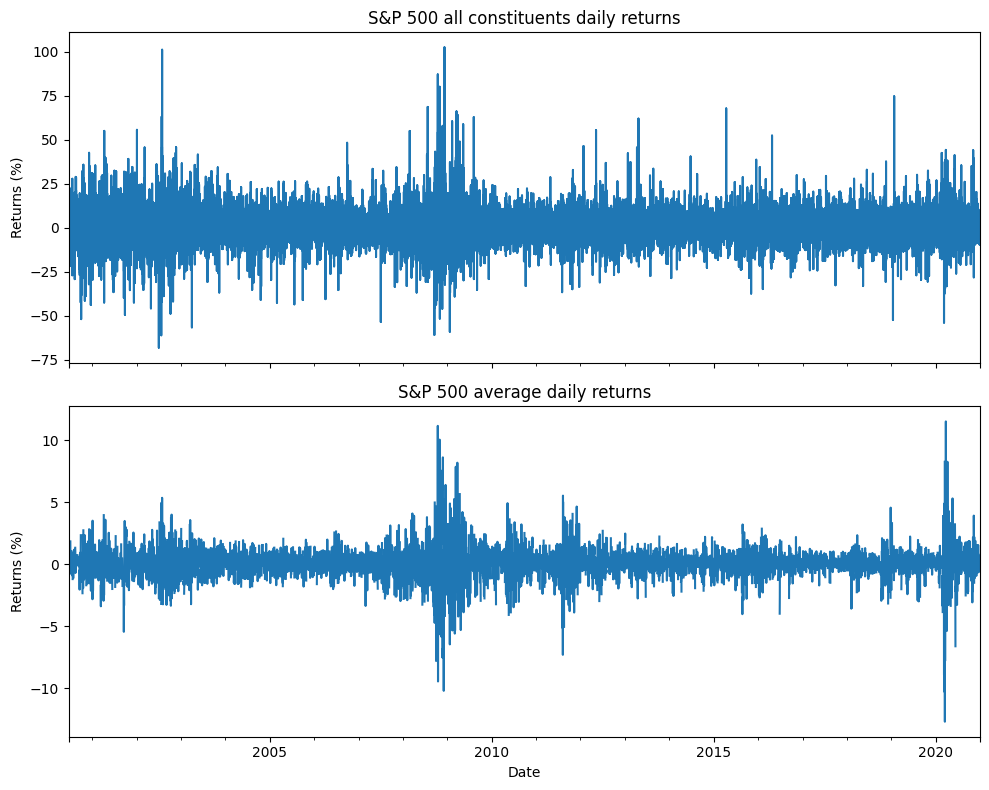

In [ ]:
# create figure and axes
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# plot returns for all S&P 500 stocks overlayed
main_df['return_t-1'][:end_valid_date].plot(ax=axs[0])
axs[0].set_title('S&P 500 all constituents daily returns')
axs[0].set_ylabel('Returns (%)')

# plot returns for S&P 500 average
main_df['return_t-1'][:end_valid_date].resample('D').mean().plot(ax=axs[1])
axs[1].set_title('S&P 500 average daily returns')
axs[1].set_ylabel('Returns (%)')

# show plot
plt.tight_layout()
plt.show()

In [ ]:
# check class imbalance
print(f"""
    Positive class: {main_df['y'][:end_valid_date].value_counts(normalize=True)[1]:.4f}
    Negative class: {main_df['y'][:end_valid_date].value_counts(normalize=True)[0]:.4f}
""")


    Positive class: 0.5147
    Negative class: 0.4853



# Feature selection

## Preprocessing

In [ ]:
main_df = downcast(main_df)

In [ ]:
# partition main df into train validation test sets
train_df = main_df[:end_train_date]
valid_df = main_df[end_train_date:end_valid_date]
train_valid_df = main_df[:end_valid_date]
test_df = main_df[end_valid_date:]

# split training data into X and y
X_train = train_df.drop('y', axis=1)
y_train = train_df['y']

# split validation data into X and y
X_valid = valid_df.drop('y', axis=1)
y_valid = valid_df['y']

# split training+validation data into X and y
X_train_valid = train_valid_df.drop('y', axis=1)
y_train_valid = train_valid_df['y']

# split test data into X and y
X_test = test_df.drop('y', axis=1)
y_test = test_df['y']

# df used for decision threshold optimisation
prices_df = main_df[['Ticker', 'Open', 'Close', 'Adj Close']]

# df used for trading performance review
perf_df = test_df[['Ticker','Adj Close','Adj Close_return_1t']]

## Hyperparameter Tuning (Very heavy to run. Best params saved in the next section)

In [ ]:
# create preprocessor for categorical variable
cat_preprocessor = make_column_transformer(
    (OrdinalEncoder(), ['Ticker']),
    remainder='passthrough'
)

In [ ]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', cat_preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

In [ ]:
params = {
    'model__n_estimators': [100, 250, 400],
    'model__max_depth': [None, 10, 15],
    'model__max_samples': [0.3, 0.5, 0.7],
}

In [ ]:
tscv = TimeSeriesSplit(n_splits=3, test_size=252)

rf_gs = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=params,
    n_iter=20,
    scoring='precision',
    n_jobs=4,
    refit=True,
    cv=tscv,
    verbose=2,
    random_state=42,
)

In [ ]:
#This takes very long time.
rf_gs.fit(X_train_valid, y_train_valid)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(add_indicator=True,
                                                                                                              strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_colum...
                                                                                                               handle_unknown='use_encoded_value',
                                                                                                               unknown_value=-1))]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x7b48e0039180>)])),
                                             ('model',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=20, n_jobs=4,
                   param_distributions={'model__max_depth': [5, 10, 15],
                                        'model__max_samples': [0.3, 0.5, 0.7],
                                        'model__n_estimators': [100, 250, 400]},
                   random_state=42, scoring='precision', verbose=2)

In [ ]:
# #save fitted model to joblib
# rf_to_save = '/content/drive/My Drive/Colab Notebooks/Capstone/best_rf_model_new.joblib'
# dump(rf_gs, rf_to_save)
# print(f"Model saved to {rf_to_save}")

In [ ]:
#uncomment below if you want to take best param from fitted model
#best_parameters = rf_gs.best_params_

#hard corded best parameters derived from the fitted RandomizedSerachCV above
best_parameters = {'model__n_estimators': 400, 'model__max_samples': 0.5, 'model__max_depth': None}
print("Best Parameters:", best_parameters)

Best Parameters: {'model__n_estimators': 400, 'model__max_samples': 0.5, 'model__max_depth': None}


In [ ]:
# Get the precision score of the best model
best_precision_score = rf_gs.best_score_
print("Best precision score:", best_precision_score)
# Best precision score: 0.668161252427975

## Identifying top features

In [ ]:
#uncomment below to retreive importance dict from the fitted model above section. Hard coded dict is in the next cell.

# best_rf = rf_gs.best_estimator_
# random_forest_model = best_rf.named_steps['model']
# feature_importances = random_forest_model.feature_importances_

# feature_names = X_train_valid.columns.tolist()
# importances_dict = dict(zip(feature_names, feature_importances))

In [ ]:
#hard coded version of the result of the cell above.

importances_dict = {'Ticker': 0.010722863337534992,
 'Adj Close': 0.008662315751101617,
 'Close': 0.008292848764845179,
 'High': 0.008300473296976552,
 'Low': 0.008292874753904653,
 'Open': 0.008299596647730258,
 'Volume': 0.011646104354985918,
 'FFE_Rate': 0.0089308164463183,
 '10yr_UST': 0.015088049976344897,
 'CPI_Core': 0.003746272302474327,
 'CPI_Core_%': 0.0022900845115396756,
 'Nonfarm_Payroll': 0.0035123763857999846,
 'Nonfarm_Payroll_%': 0.0016994167748784026,
 'Unemployment_Rate': 0.0026782666899820297,
 'Unemployment_Rate_%': 0.001174287549664832,
 'PCE': 0.0035226826069337043,
 'PCE_%': 0.0017576316478287383,
 'Ind_Prod': 0.003925062753747582,
 'Ind_Prod_%': 0.0021767342224030526,
 'CPI_Core_%_7d_ma': 0.0030194421221052116,
 'CPI_Core_%_30d_ma': 0.004993916934308271,
 'CPI_Core_%_60d_ma': 0.0052755101188526445,
 'CPI_Core_%_90d_ma': 0.005258832345551533,
 'Nonfarm_Payroll_%_7d_ma': 0.003039928674196289,
 'Nonfarm_Payroll_%_30d_ma': 0.004664072570023018,
 'Nonfarm_Payroll_%_60d_ma': 0.004846021723256605,
 'Nonfarm_Payroll_%_90d_ma': 0.004594602384790123,
 'Unemployment_Rate_%_7d_ma': 0.0021301893534416715,
 'Unemployment_Rate_%_30d_ma': 0.003531249174707118,
 'Unemployment_Rate_%_60d_ma': 0.004147352523944917,
 'Unemployment_Rate_%_90d_ma': 0.004013633122700858,
 'PCE_%_7d_ma': 0.003475351807665987,
 'PCE_%_30d_ma': 0.004731065560521791,
 'PCE_%_60d_ma': 0.004937739881344288,
 'PCE_%_90d_ma': 0.004858784645970255,
 'Ind_Prod_%_7d_ma': 0.0035004279534018856,
 'Ind_Prod_%_30d_ma': 0.00469342423138033,
 'Ind_Prod_%_60d_ma': 0.004733150938579046,
 'Ind_Prod_%_90d_ma': 0.004793586675927284,
 'GDP': 0.0035143697054424126,
 'GDP_%': 0.0022291742144255897,
 'GDP_%_7d_ma': 0.0033660508703652215,
 'GDP_%_30d_ma': 0.00471923462105269,
 'GDP_%_60d_ma': 0.004932008029692756,
 'GDP_%_90d_ma': 0.004931542994767991,
 'upper_bband': 0.008709348414560076,
 'lower_bband': 0.008701574462330199,
 'ATR': 0.010862816957173331,
 'macd': 0.010153851738836287,
 'macd_sginal': 0.010486864341548547,
 'RSI': 0.010432873471858894,
 'ADX': 0.011338740439945379,
 'return': 0.011336541370133235,
 'return_class': 0.00094240968442555,
 'Adj Close_agg_mean': 0.017996079590424326,
 'Volume_agg_mean': 0.01900166116626477,
 'Adj Close_agg_std': 0.0176746660062746,
 'Volume_agg_std': 0.018429364496336434,
 'Adj Close_return_1t': 0.011391512383782358,
 'Adj Close_return_2t': 0.010920204366605674,
 'Adj Close_return_3t': 0.010214300982682518,
 'Adj Close_return_4t': 0.009760774246292873,
 'Adj Close_return_5t': 0.009142002280445842,
 'Adj Close_return_6t': 0.009801905187115283,
 'Adj Close_return_7t': 0.010015028078154513,
 'Adj Close_return_8t': 0.010054601742492973,
 'Adj Close_return_9t': 0.009968998965322402,
 'Adj Close_return_10t': 0.009856938034475512,
 'Open_return_1t': 0.011603179474742318,
 'High_return_1t': 0.011558003169391193,
 'Low_return_1t': 0.011803520598286411,
 'Volume_return_1t': 0.011844699137828405,
 'Open_return_2t': 0.01067740080190067,
 'High_return_2t': 0.010473697110714511,
 'Low_return_2t': 0.010681548548631842,
 'Volume_return_2t': 0.011554899646955776,
 'Open_return_3t': 0.01014825527074703,
 'High_return_3t': 0.009902803009359012,
 'Low_return_3t': 0.0100048306962855,
 'Volume_return_3t': 0.011446654437828711,
 'Open_return_4t': 0.009788391165212748,
 'High_return_4t': 0.009475662893026286,
 'Low_return_4t': 0.009651577145463027,
 'Volume_return_4t': 0.011401940559271405,
 'Open_return_5t': 0.009948065374892642,
 'High_return_5t': 0.009381811867104704,
 'Low_return_5t': 0.009540051476712833,
 'Volume_return_5t': 0.011464656698762263,
 'return_t-1': 0.011776116214679644,
 'return_class_t-1': 0.0011786438225306222,
 'return_t-2': 0.012189627829781275,
 'return_class_t-2': 0.0012757051530787405,
 'return_t-3': 0.012460709198625408,
 'return_class_t-3': 0.0013692288454250651,
 'return_t-4': 0.012373908327341721,
 'return_class_t-4': 0.0013276266431362994,
 'return_t-5': 0.012681874365041,
 'return_class_t-5': 0.0013838891764352628,
 'return_t-6': 0.012905072525344109,
 'return_class_t-6': 0.001428434494897517,
 'return_t-7': 0.013075456484062276,
 'return_class_t-7': 0.0014650697740295272,
 'return_t-8': 0.013023756298697288,
 'return_class_t-8': 0.001464162099946545,
 'return_t-9': 0.013097187167829403,
 'return_class_t-9': 0.001470516700486674,
 'return_t-10': 0.013312258111606183,
 'return_class_t-10': 0.0015068720640722664,
 'return_mean_5t': 0.009164769568280681,
 'return_std_5t': 0.010119127645449111,
 'return_min_5t': 0.010005484062539425,
 'return_max_5t': 0.00998324103155052,
 'return_mean_10t': 0.009849050304765567,
 'return_std_10t': 0.010100707424420416,
 'return_min_10t': 0.010065614526372718,
 'return_max_10t': 0.010022449504535071,
 'return_mean_20t': 0.010885844115946857,
 'return_std_20t': 0.010496836733128628,
 'return_min_20t': 0.010391018084866109,
 'return_max_20t': 0.010394401827273738,
 'return_mean_60t': 0.011571600234364576,
 'return_std_60t': 0.011195949505445755,
 'return_min_60t': 0.010901479059406248,
 'return_max_60t': 0.01089218163059843}

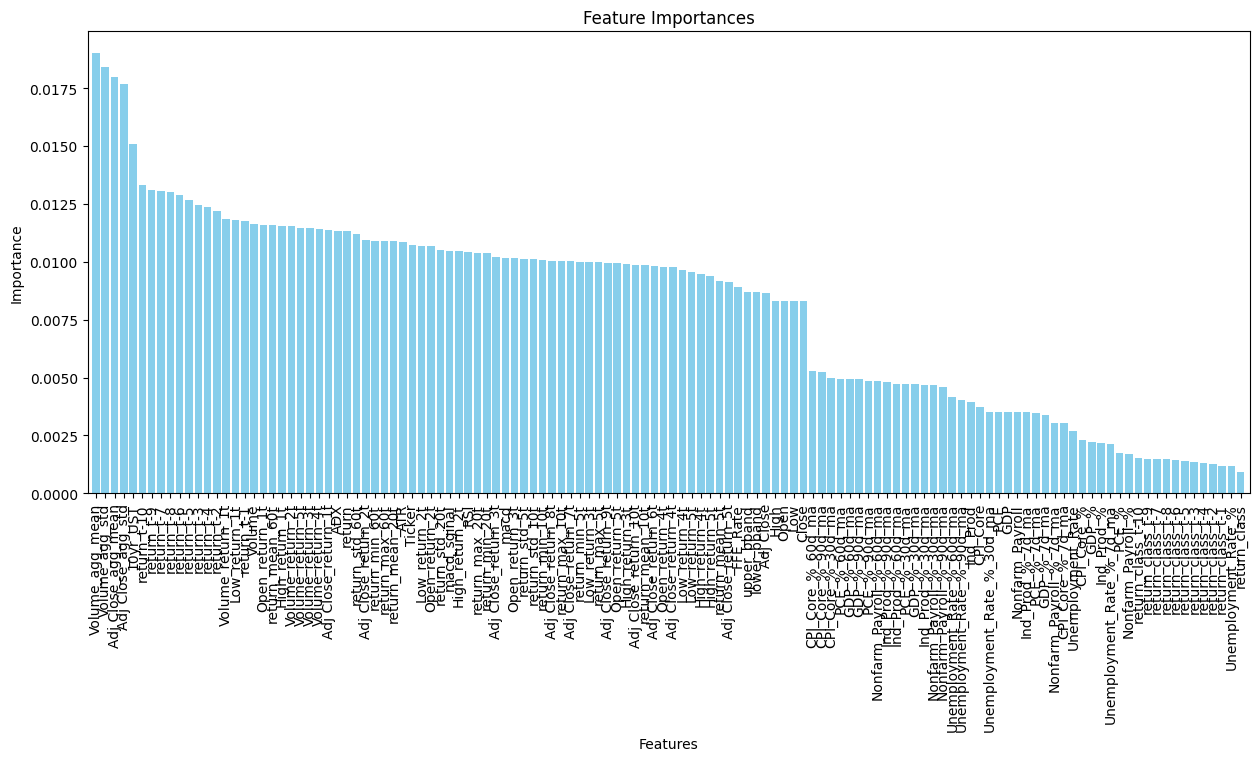

In [ ]:
# plotting

sorted_importances = sorted(importances_dict.items(), key=lambda item: item[1], reverse=True)
features, importances = zip(*sorted_importances)

plt.figure(figsize=(15, 6))
plt.bar(features, importances, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xlim(-0.9, len(features))  # Set limits to reduce white space

plt.xticks(rotation=90)
plt.show()

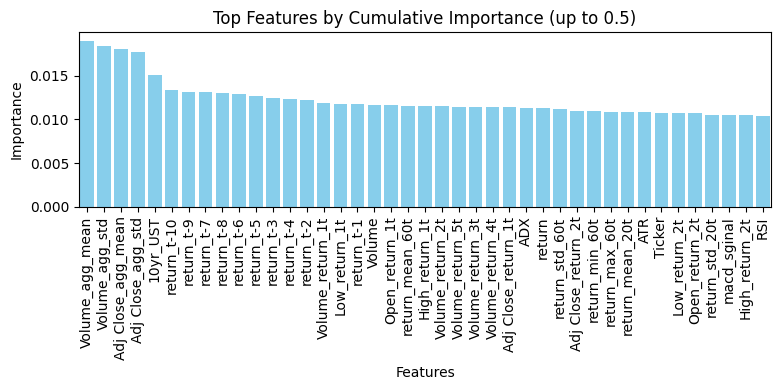

In [ ]:
# setting threshold of cumulative importance to cut off features
threshold = 0.5

# Filtering features by cumulative importance up to threshold
cumulative_importance = 0.0
filtered_features = []
for feature, importance in sorted_importances:
    cumulative_importance += importance
    filtered_features.append((feature, importance,cumulative_importance))
    if cumulative_importance >= threshold:
        break

# Unpacking the filtered items into two lists for plotting
filtered_feature_names, filtered_importances,cumulative_importance = zip(*filtered_features)

# Creating the bar plot for filtered features
plt.figure(figsize=(8, 4))
plt.bar(filtered_feature_names, filtered_importances, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top Features by Cumulative Importance (up to 0.5)')
plt.xticks(rotation=90)
plt.xlim(-0.5, len(filtered_feature_names)-0.5)  # Adjusting the x-axis limits to reduce white space
plt.tight_layout()
plt.show()

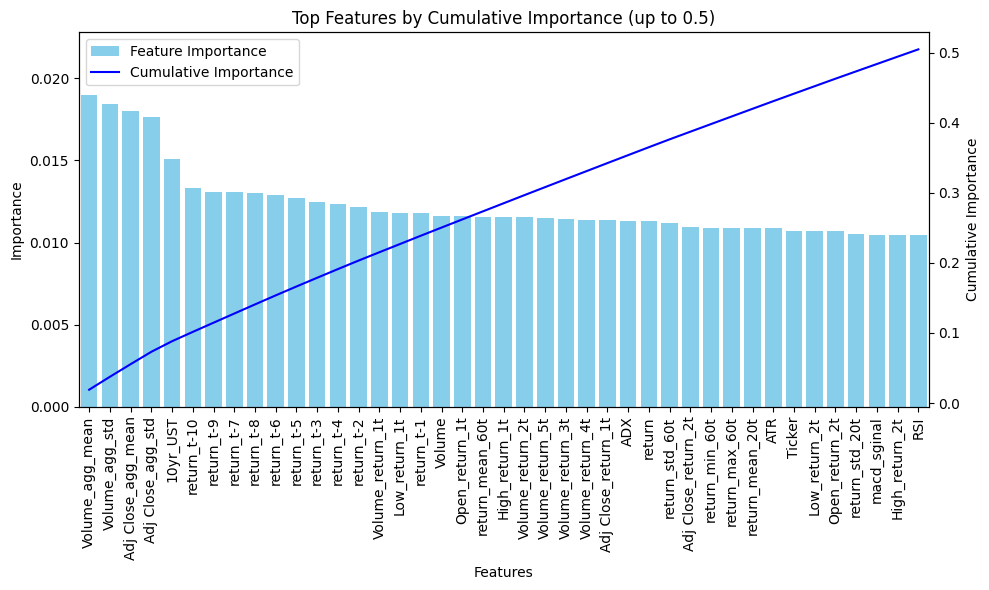

In [ ]:
# setting threshold of cumulative importance to cut off features
threshold = 0.5

# Filtering features by cumulative importance up to threshold
cumulative_importance = 0.0
filtered_features = []
for feature, importance in sorted_importances:
    cumulative_importance += importance
    filtered_features.append((feature, importance, cumulative_importance))
    if cumulative_importance >= threshold:
        break

# Unpacking the filtered items into three lists for plotting
filtered_feature_names, filtered_importances, cumulative_importance = zip(*filtered_features)

# Creating the bar plot for filtered features
fig, ax1 = plt.subplots(figsize=(10, 6))  # Increased height to provide more room for the bar chart

# Plotting the bar chart on the primary y-axis
bar = ax1.bar(filtered_feature_names, filtered_importances, color='skyblue', label='Feature Importance')
ax1.set_xlabel('Features')
ax1.set_ylabel('Importance')
ax1.set_title('Top Features by Cumulative Importance (up to 0.5)')
ax1.tick_params(axis='x', rotation=90)

# Adjusting y-axis limits to show the bar chart fully
ax1.set_ylim(0, max(filtered_importances) * 1.2)  # Adjust multiplier as needed to provide more room

# Creating a secondary y-axis for cumulative importance
ax2 = ax1.twinx()
line = ax2.plot(filtered_feature_names, cumulative_importance, color='blue', label='Cumulative Importance')
ax2.set_ylabel('Cumulative Importance')

# Adding legend
plots = [bar, line[0]]
labels = [plot.get_label() for plot in plots]
ax1.legend(plots, labels, loc='upper left')

# Show plot
plt.xlim(-0.5, len(filtered_feature_names)-0.5)  # Adjusting the x-axis limits to reduce white space
plt.tight_layout()
plt.show()



In [ ]:
list(filtered_feature_names)

['Volume_agg_mean',
 'Volume_agg_std',
 'Adj Close_agg_mean',
 'Adj Close_agg_std',
 '10yr_UST',
 'return_t-10',
 'return_t-9',
 'return_t-7',
 'return_t-8',
 'return_t-6',
 'return_t-5',
 'return_t-3',
 'return_t-4',
 'return_t-2',
 'Volume_return_1t',
 'Low_return_1t',
 'return_t-1',
 'Volume',
 'Open_return_1t',
 'return_mean_60t',
 'High_return_1t',
 'Volume_return_2t',
 'Volume_return_5t',
 'Volume_return_3t',
 'Volume_return_4t',
 'Adj Close_return_1t',
 'ADX',
 'return',
 'return_std_60t',
 'Adj Close_return_2t',
 'return_min_60t',
 'return_max_60t',
 'return_mean_20t',
 'ATR',
 'Ticker',
 'Low_return_2t',
 'Open_return_2t',
 'return_std_20t',
 'macd_sginal',
 'High_return_2t',
 'RSI']

## removing features under threshold

In [10]:
#hard-cording top features with threshold = 0.5
top_features = ['Volume_agg_mean',
 'Volume_agg_std',
 'Adj Close_agg_mean',
 'Adj Close_agg_std',
 '10yr_UST',
 'return_t-10',
 'return_t-9',
 'return_t-7',
 'return_t-8',
 'return_t-6',
 'return_t-5',
 'return_t-3',
 'return_t-4',
 'return_t-2',
 'Volume_return_1t',
 'Low_return_1t',
 'return_t-1',
 'Volume',
 'Open_return_1t',
 'return_mean_60t',
 'High_return_1t',
 'Volume_return_2t',
 'Volume_return_5t',
 'Volume_return_3t',
 'Volume_return_4t',
 'Adj Close_return_1t',
 'ADX',
 'return',
 'return_std_60t',
 'Adj Close_return_2t',
 'return_min_60t',
 'return_max_60t',
 'return_mean_20t',
 'ATR',
 'Ticker',
 'Low_return_2t',
 'Open_return_2t',
 'return_std_20t',
 'macd_sginal',
 'High_return_2t',
 'RSI']

# df used for decision threshold optimisation
prices_df = main_df[['Ticker', 'Open', 'Close', 'Adj Close']]

#replace main_df with selected features
main_df = main_df[['y']+top_features]
main_df.shape

(2633373, 42)

# Train validation test split with updated main_df (reduced features)

In [11]:
main_df = downcast(main_df)

In [14]:
# partition main df into train validation test sets
train_df = main_df[:end_train_date]
valid_df = main_df[end_train_date:end_valid_date]
train_valid_df = main_df[:end_valid_date]
test_df = main_df[end_valid_date:]

# split training data into X and y
X_train = train_df.drop('y', axis=1)
y_train = train_df['y']

# split validation data into X and y
X_valid = valid_df.drop('y', axis=1)
y_valid = valid_df['y']

# split training+validation data into X and y
X_train_valid = train_valid_df.drop('y', axis=1)
y_train_valid = train_valid_df['y']

# split test data into X and y
X_test = test_df.drop('y', axis=1)
y_test = test_df['y']

# Benchmark DummyClassifier

In [ ]:
# time series cross validation
# 252 trading days equals one calendar year mult. by # of constituents
tscv = TimeSeriesSplit(n_splits=3, test_size=(252*500))

In [ ]:
def show_precision_score(model, name, X, y):

    # compute mean cross-validated precision score
    scores = cross_val_score(
        estimator=model,
        X=X,
        y=y,
        scoring='precision',
        cv=tscv,
        n_jobs=6,
    )

    # display mean and std of stacking classifier
    print(f"""
        Cross-validated precision score for
        {name}
        - - -
        Mean: \t\t{scores.mean():.3f}
        Std dev: \t{scores.std():.3f}
    """)

In [ ]:
# instantiate and fit dummy classifier always predicting the positive class
# this is equivalent to a buy-and-hold trading strategy
dummy_clf = DummyClassifier(strategy='constant', constant=1)
dummy_clf.fit(X_train, y_train)

# RandomForest

## Preprocessing pipeline

In [ ]:
# preprocessing for numerical variables
numerical_transformer = make_pipeline(
    SimpleImputer(strategy='median', add_indicator=True),
    StandardScaler(),
)

# preprocessing for categorical variables
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent', add_indicator=True),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=np.float32),
)

# combine above two preprocessing steps into one pipeline step
preprocessor = make_column_transformer(
    (numerical_transformer, make_column_selector(dtype_exclude=object)),
    (categorical_transformer, make_column_selector(dtype_include=object)),
)

In [ ]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

## Hyperparameter tuning

In [ ]:
params = {
    'model__n_estimators': [250, 500],
    'model__max_depth': [10, 30],
    'model__min_samples_split': [2, 10],
    'model__min_samples_leaf': [2, 4],
    'model__max_features': ['sqrt', 0.5]
}

In [ ]:
tscv = TimeSeriesSplit(n_splits=3, test_size=252)

rf_gs = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=params,
    n_iter=27,
    scoring='precision',
    n_jobs=4,
    refit=True,
    cv=tscv,
    verbose=2,
    random_state=42,
)

In [ ]:
rf_gs.fit(X_train, y_train)

In [ ]:
# Predicting with the best model found by RandomizedSearchCV
y_pred = rf_gs.predict(X_valid)

# Calculating the precision score
precision = precision_score(y_valid, y_pred, average='binary')
print(f'Precision Score: {precision}')
# Precision Score: 0.5480978474607378

In [ ]:
# Get the precision score of the best model
best_precision_score = rf_gs.best_score_
print("Best precision score:", best_precision_score)
#Best precision score: 0.9082125603864735

In [ ]:
#rf_gs.best_params_

# {'model__n_estimators': 250,
#  'model__min_samples_split': 10,
#  'model__min_samples_leaf': 4,
#  'model__max_features': 0.5,
#  'model__max_depth': 30}

## Cross-validation

In [ ]:
tscv = TimeSeriesSplit(n_splits=3, test_size=252*500)

# Directly using the best estimator found
rf_cv = cross_val_score(rf_gs.best_estimator_, X_train_valid, y_train_valid, cv=tscv, scoring='precision')
print("Precision scores for each fold are:", rf_cv)
print(f'mean: {rf_cv.mean():.3f}')
print(f'Std dev: {rf_cv.std():.3f}')

# Precision scores for each fold are: [0.53567451 0.56025311 0.50686697]
# mean: 0.534
# Std dev: 0.022

In [6]:
# to save time, instead of refitting the model, just run this cell to retrieve a fully fitted model
url = 'https://drive.google.com/uc?id=1JXK-A3j3DDIrJ7gf93tgqTowYCa1cygs'
output = 'rf_cv.joblib'
gdown.download(url, output, quiet=False)
rf_cv = joblib.load('rf_cv.joblib')

Downloading...
From (original): https://drive.google.com/uc?id=1JXK-A3j3DDIrJ7gf93tgqTowYCa1cygs
From (redirected): https://drive.google.com/uc?id=1JXK-A3j3DDIrJ7gf93tgqTowYCa1cygs&confirm=t&uuid=45bb5dd9-7d41-4ef7-bd92-5ddff52efed2
To: /content/rf_cv.joblib
100%|██████████| 2.28G/2.28G [00:33<00:00, 68.7MB/s]


# LightGBM

## Preprocessing pipeline

In [ ]:
# preprocessing for numerical variables
numerical_transformer = make_pipeline(
    SimpleImputer(strategy='median', add_indicator=True),
    StandardScaler(),
)

# preprocessing for categorical variables
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent', add_indicator=True),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=np.float32),
)

# combine above two preprocessing steps into one pipeline step
preprocessor = make_column_transformer(
    (numerical_transformer, make_column_selector(dtype_exclude=object)),
    (categorical_transformer, make_column_selector(dtype_include=object)),
)

In [ ]:
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state=42))
])

## Hypterparameter tuning

In [ ]:
lgbm_params = {
    'model__num_leaves': [50, 70],
    'model__learning_rate': [0.01, 0.05],
    'model__n_estimators': [100, 300],
    'model__lambda_l1': [0.1, 0.5],
    'model__lambda_l2': [0.1, 0.5],
}

In [ ]:
tscv = TimeSeriesSplit(n_splits=3, test_size=252*500)

# Setup RandomizedSearchCV
lgbm_rs = RandomizedSearchCV(
    lgbm_pipeline,
    param_distributions=lgbm_params,
    n_iter=20,
    scoring='precision',
    n_jobs=1,
    refit=True,
    cv=tscv,
    verbose=2,
    random_state=42,
)

In [ ]:
lgbm_rs.fit(X_train, y_train)

In [ ]:
#specify the location of the file to load
lgbm_load_from = '/content/drive/My Drive/Colab Notebooks/Capstone/lgbm_rs_result_revised_more_param.joblib'
lgbm_gs = load(lgbm_load_from)

In [ ]:
# Predicting with the best model found by RandomizedSearchCV
y_pred = lgbm_rs.predict(X_valid)

# Calculating the precision score
precision = precision_score(y_valid, y_pred, average='binary')  # adjust 'average' as needed
print(f'Precision Score: {precision}')
# Precision Score: 0.5484275565699246

In [ ]:
# Get the precision score of the best model
best_precision_score = lgbm_rs.best_score_
print("Best precision score:", best_precision_score)
#Best precision score: 0.538967886340679

In [ ]:
lgbm_rs.best_params_
# {'model__num_leaves': 50,
#  'model__n_estimators': 300,
#  'model__learning_rate': 0.05,
#  'model__lambda_l2': 0.1,
#  'model__lambda_l1': 0.5}

## Cross-validation

In [ ]:
tscv = TimeSeriesSplit(n_splits=3, test_size=252*500)

# Directly using the best estimator found
lgbm_cv = cross_val_score(lgbm_rs.best_estimator_, X_train_valid, y_train_valid, cv=tscv, scoring='precision')

print("Precision scores for each fold are:", lgbm_cv)
print(f'mean: {lgbm_cv.mean():.3f}')
print(f'Std dev: {lgbm_cv.std():.3f}')

# Precision scores for each fold are: [0.51940317 0.59531874 0.51591248]
# mean: 0.544
# Std dev: 0.037

In [16]:
# to save time, instead of refitting the model, just run this cell to retrieve a fully fitted model
url = 'https://github.com/vzinkovski/umich_siads_capstone/raw/main/lgbm_rs_result_revised_more_param.joblib'
output = 'lgbm_rs_result_revised_more_param.joblib'
gdown.download(url, output, quiet=False)
lgbm_cv = joblib.load('lgbm_rs_result_revised_more_param.joblib')

Downloading...
From: https://github.com/vzinkovski/umich_siads_capstone/raw/main/lgbm_rs_result_revised_more_param.joblib
To: /content/lgbm_rs_result_revised_more_param.joblib
100%|██████████| 1.71M/1.71M [00:00<00:00, 6.67MB/s]


# Deep Neural Network (DNN)

## Define neural network architecture

In [ ]:
class ReturnsClassifier(nn.Module):

    def __init__(
            self,
            num_units_1st=10,
            num_units_2nd=10,
            nonlin=F.relu,
            dropout=0.1,
    ):

        # initialise model
        super(ReturnsClassifier, self).__init__()
        self.num_units_1st = num_units_1st
        self.num_units_2nd = num_units_2nd
        self.nonlin = nonlin
        self.dropout = dropout

        # first hidden layer
        self.dense0 = nn.Linear((main_df.shape[1]-1), num_units_1st)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(dropout)

        # second hidden layer
        self.dense1 = nn.Linear(num_units_1st, num_units_2nd)
        self.output = nn.Linear(num_units_2nd, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X), dim=-1)
        return X

In [ ]:
# set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
# define callbacks to monitor precision
precision_callback = EpochScoring(scoring='precision', lower_is_better=False)

# instantiate skorch deep learning model
net = NeuralNetClassifier(
    module=ReturnsClassifier,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.SGD,
    train_split=None,
    iterator_train__shuffle=False,
    callbacks=[precision_callback],
    verbose=0,
    # device='cuda',  # uncomment to toggle between cpu/gpu
)

## Hyperparameter tuning

In [ ]:
# preprocessing for numerical variables
numerical_transformer = make_pipeline(
    SimpleImputer(strategy='median', add_indicator=True),
    StandardScaler(),
)

# preprocessing for categorical variables
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent', add_indicator=True),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=np.float32),
)

# combine above two preprocessing steps into one pipeline step
preprocessor = make_column_transformer(
    (numerical_transformer, make_column_selector(dtype_exclude=object)),
    (categorical_transformer, make_column_selector(dtype_include=object)),
)

In [ ]:
tscv = TimeSeriesSplit(n_splits=3, test_size=252*500)

# preprocessing pipeline with deep learning model at the end
pipe = make_pipeline(
    preprocessor,
    net,
)

# hyperparameter search space for deep learning model
params = {
    'neuralnetclassifier__lr': [0.001, 0.01, 0.1, 0.2],
    'neuralnetclassifier__max_epochs': [10, 20, 50],
    'neuralnetclassifier__batch_size': [64, 128, 256, 512],
    'neuralnetclassifier__module__num_units_1st': [10, 20, 30],
    'neuralnetclassifier__module__num_units_2nd': [5, 10],
    'neuralnetclassifier__module__dropout': [0, 0.1, 0.25],
}

# use random grid search to find optimal hypeparams combo for precision metric
dnn_model = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=params,
    n_iter=20,
    scoring='precision',
    n_jobs=6,
    refit=True,
    cv=tscv,
    verbose=4,
    random_state=42,
)

In [ ]:
%%time

# fit deep neural network with optimal hyperparams
dnn_model.fit(X_train, y_train.astype(np.int64))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END neuralnetclassifier__batch_size=512, neuralnetclassifier__lr=0.01, neuralnetclassifier__max_epochs=20, neuralnetclassifier__module__dropout=0, neuralnetclassifier__module__num_units_1st=10, neuralnetclassifier__module__num_units_2nd=5;, score=0.510 total time= 6.3min
[CV 2/3] END neuralnetclassifier__batch_size=512, neuralnetclassifier__lr=0.01, neuralnetclassifier__max_epochs=20, neuralnetclassifier__module__dropout=0, neuralnetclassifier__module__num_units_1st=10, neuralnetclassifier__module__num_units_2nd=5;, score=0.527 total time= 7.0min
[CV 3/3] END neuralnetclassifier__batch_size=512, neuralnetclassifier__lr=0.01, neuralnetclassifier__max_epochs=20, neuralnetclassifier__module__dropout=0, neuralnetclassifier__module__num_units_1st=10, neuralnetclassifier__module__num_units_2nd=5;, score=0.535 total time= 7.2min
[CV 1/3] END neuralnetclassifier__batch_size=64, neuralnetclassifier__lr=0.2, neuralnetclassifie

/Users/v.zinkovski/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/3] END neuralnetclassifier__batch_size=256, neuralnetclassifier__lr=0.2, neuralnetclassifier__max_epochs=50, neuralnetclassifier__module__dropout=0, neuralnetclassifier__module__num_units_1st=30, neuralnetclassifier__module__num_units_2nd=10;, score=0.535 total time=18.5min
[CV 3/3] END neuralnetclassifier__batch_size=64, neuralnetclassifier__lr=0.2, neuralnetclassifier__max_epochs=50, neuralnetclassifier__module__dropout=0, neuralnetclassifier__module__num_units_1st=10, neuralnetclassifier__module__num_units_2nd=5;, score=0.552 total time=28.2min
[CV 1/3] END neuralnetclassifier__batch_size=64, neuralnetclassifier__lr=0.001, neuralnetclassifier__max_epochs=20, neuralnetclassifier__module__dropout=0, neuralnetclassifier__module__num_units_1st=30, neuralnetclassifier__module__num_units_2nd=10;, score=0.510 total time=10.1min
[CV 2/3] END neuralnetclassifier__batch_size=64, neuralnetclassifier__lr=0.001, neuralnetclassifier__max_epochs=20, neuralnetclassifier__module__dropout=0, ne

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=126000),
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(add_indicator=True,
                                                                                                              strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.mak...
                   param_distributions={'neuralnetclassifier__batch_size': [64,
                                                                            128,
                                                                            256,
                                                                            512],
                                        'neuralnetclassifier__lr': [0.001, 0.01,
                                                                    0.1, 0.2],
                                        'neuralnetclassifier__max_epochs': [10,
                                                                            20,
                                                                            50],
                                        'neuralnetclassifier__module__dropout': [0,
                                                                                 0.1,
                                                                                 0.25],
                                        'neuralnetclassifier__module__num_units_1st': [10,
                                                                                       20,
                                                                                       30],
                                        'neuralnetclassifier__module__num_units_2nd': [5,
                                                                                       10]},
                   random_state=42, scoring='precision', verbose=4)

In [ ]:
def show_score_hyperparams(rscv_model, name):

    # display best hyperparameter combo
    print(f'Best hyperparameters for {name}')
    print('- - -')
    for param, value in rscv_model.best_params_.items():
        print(f'{param}: {value}')

    # display performance metrics
    print(f"""
    Cross-validated precision score
    - - -
    Mean: \t{rscv_model.cv_results_['mean_test_score'][rscv_model.best_index_]:.3f}
    Std dev: \t{rscv_model.cv_results_['std_test_score'][rscv_model.best_index_]:.3f}
    """)

In [ ]:
# show best precision score and hyperparams
show_score_hyperparams(dnn_model, 'DEEP NEURAL NETWORK')

Best hyperparameters for DEEP NEURAL NETWORK
- - -
neuralnetclassifier__module__num_units_2nd: 10
neuralnetclassifier__module__num_units_1st: 30
neuralnetclassifier__module__dropout: 0
neuralnetclassifier__max_epochs: 50
neuralnetclassifier__lr: 0.2
neuralnetclassifier__batch_size: 256

    Cross-validated precision score
    - - -
    Mean: 	0.548
    Std dev: 	0.038
    


In [ ]:
# reinstantiate dnn model with best hyperparameters
dnn_model = dnn_model.best_estimator_

# Ensemble models

Note: In order to save time, the below code cells can be run directly provided the main_df has already been loaded in. This will skip the hyperparameter optimisation via cross validation stage and directly proceed to reinstantiate the models with their best found hyperparameters.

In [ ]:
# preprocessing for numerical variables
numerical_transformer = make_pipeline(
    SimpleImputer(strategy='median', add_indicator=True),
    StandardScaler(),
)

# preprocessing for categorical variables
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent', add_indicator=True),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=np.float32),
)

# combine above two preprocessing steps into one pipeline step
preprocessor = make_column_transformer(
    (numerical_transformer, make_column_selector(dtype_exclude=object)),
    (categorical_transformer, make_column_selector(dtype_include=object)),
)

In [ ]:
# random forest best hyperparameters
rf_best_params = {
    'n_estimators': 250,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'max_features': 0.5,
    'max_depth': 30
}

# pipeline with preprocessor and random forest using best hyperparams
rf_model = make_pipeline(
    preprocessor,
    RandomForestClassifier(random_state=42, **rf_best_params, n_jobs=6),
)

# lightgbm best hyperparameters
lgbm_best_params = {
    'num_leaves': 50,
    'n_estimators': 300,
    'learning_rate': 0.05,
    'lambda_l2': 0.1,
    'lambda_l1': 0.5
}

# pipeline with preprocessor and lightgbm using best hyperparams
lgbm_model = make_pipeline(
    preprocessor,
    LGBMClassifier(random_state=42, **lgbm_best_params),
)

In [ ]:
# reset random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# define callbacks to monitor precision
precision_callback = EpochScoring(scoring='precision', lower_is_better=False)

# instantiate skorch deep learning model
net = NeuralNetClassifier(
    module=ReturnsClassifier,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.SGD,
    train_split=None,
    iterator_train__shuffle=False,
    callbacks=[precision_callback],
    verbose=0,
    max_epochs=50,
    lr=0.2,
    batch_size=256,
    # device='cuda',  # uncomment to toggle between cpu/gpu
)

# pipeline with preprocessor and deep neural net using best hyperparams
dnn_model = make_pipeline(
    preprocessor,
    net,
)

In [ ]:
# collect classifier models into a list
estimators = [
    ("rf_clf", rf_model),
    ("lgbm_clf", lgbm_model),
    ("dnn_clf", dnn_model),
]

## VotingClassifier

In [ ]:
# instantiate voting classifier ensemble model
voting_clf  = VotingClassifier(
    estimators=estimators,
    voting='soft',
    n_jobs=6,
)

## StackingClassifier

In [ ]:
# instantiate stacking classifier ensemble model
stacking_clf  = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=42)
    n_jobs=6,
)

# Evaluation

In [ ]:
%%time

# cross validated mean precision score for dummy_clf
show_precision_score(dummy_clf, 'DUMMY CLASSIFIER', X_train_valid, y_train_valid)


        Cross-validated precision score for
        DUMMY CLASSIFIER
        - - -
        Mean: 		0.530
        Std dev: 	0.016
    
CPU times: user 129 ms, sys: 304 ms, total: 433 ms
Wall time: 3.61 s


In [ ]:
%%time

# set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# cross validated mean precision score for deep neural net
show_precision_score(dnn_model, 'DEEP NEURAL NETWORK CLASSIFIER', X_train_valid, y_train_valid.astype(np.int64))


        Cross-validated precision score for
        DEEP NEURAL NETWORK CLASSIFIER
        - - -
        Mean: 		0.521
        Std dev: 	0.013

CPU times: user 1min 7s, sys: 29.1 s, total: 4min
Wall time: 28min 39s


In [ ]:
%%time

# set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# cross validated mean precision score for voting_clf
show_precision_score(voting_clf, 'VOTING ENSEMBLE CLASSIFIER', X_train_valid, y_train_valid.astype(np.int64))


        Cross-validated precision score for
        VOTING ENSEMBLE CLASSIFIER
        - - -
        Mean: 		0.556
        Std dev: 	0.049
    
CPU times: user 3min 10s, sys: 49.9 s, total: 4min
Wall time: 7h 53min 12s


In [ ]:
%%time

# set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# cross validated mean precision score for stacking_clf
show_precision_score(stacking_clf, 'STACKING ENSEMBLE CLASSIFIER', X_train_valid, y_train_valid.astype(np.int64))


        Cross-validated precision score for
        STACKING ENSEMBLE CLASSIFIER
        - - -
        Mean: 		0.545
        Std dev: 	0.036

CPU times: user 4min 13s, sys: 32.3 s, total: 5min
Wall time: 9h 11min 25s


## Save/load best model

In [ ]:
%%time

# select best model based on above cross validation results
best_model = rf_model

# refit best model on training+validation data
best_model.fit(X_train_valid, y_train_valid.astype(np.int64))

CPU times: user 14h 10min 10s, sys: 29.5 s, total: 14h 10min 40s
Wall time: 1h 51min 19s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdad60d9f00>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(...
                                                                   OrdinalEncoder(dtype=<class 'numpy.float32'>,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdad611c490>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=30, max_features=0.5,
                                        min_samples_leaf=4,
                                        min_samples_split=10, n_estimators=250,
                                        n_jobs=-1, random_state=42))])

In [ ]:
# to save time, instead of refitting the best model, just run this cell to
# retrieve a fully fitted best model
url = 'https://drive.google.com/uc?id=1gPiFZ-z3X77x3q1M35YjR1IPR2h8gC1p'
output = 'best_model.pkl'
gdown.download(url, output, quiet=False)
with open('best_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

Downloading...
From (original): https://drive.google.com/uc?id=1gPiFZ-z3X77x3q1M35YjR1IPR2h8gC1p
From (redirected): https://drive.google.com/uc?id=1gPiFZ-z3X77x3q1M35YjR1IPR2h8gC1p&confirm=t&uuid=03df775e-3bbc-4c70-bde1-7ea0d2324747
To: /content/best_model.pkl
100%|██████████| 2.38G/2.38G [00:31<00:00, 76.4MB/s]


# Tune decision threshold

In [ ]:
# define training+validation range for prices_df
prices_df = prices_df[:end_valid_date]

In [ ]:
%%time

# predict on training+validation range
y_pred_default = best_model.predict_proba(X_train_valid)[:, 1]

CPU times: user 2min 3s, sys: 4.43 s, total: 2min 7s
Wall time: 1min 45s


In [ ]:
%%time

def objective(trial):

    # make copy to prevent overwriting
    y_pred = y_pred_default.copy()
    temp_df = prices_df.copy()

    # use optuna to find best threshold
    threshold = trial.suggest_float('threshold', 0.5, 0.99),
    y_pred[y_pred_default >= threshold] = 1
    y_pred[y_pred_default < threshold] = 0

    # compute trading signal basis new threshold
    temp_df['signal'] = y_pred
    temp_df['signal_shifted'] = temp_df.groupby('Ticker')['signal'].shift(1)
    temp_df.dropna(subset=['signal_shifted'], inplace=True)

    # compute cumulative percentage returns basis new signal
    temp_df['intraday_pct_change'] = (temp_df['Close'] - temp_df['Open']) / temp_df['Open']
    temp_df['daily_pnl'] = temp_df['signal_shifted'] * temp_df['intraday_pct_change']
    daily_mean_pnl = temp_df['daily_pnl'].resample('B').mean()
    cumulative_profit = (1 + daily_mean_pnl).cumprod()

    # maximise last day's value of cumulative return at the end of time series
    return cumulative_profit[-1]

# run bayesian hyperparameter optimisation with 30 trials
random_state = TPESampler(seed=42) # set random seed for reproducibility
study = optuna.create_study(direction='maximize', sampler=random_state)
study.optimize(objective, n_trials=50, gc_after_trial=True)

CPU times: user 39.1 s, sys: 5.76 s, total: 44.8 s
Wall time: 45 s


In [ ]:
# display best threshold
print('Best threshold: {:.3f}'.format(study.best_params['threshold']))

Best threshold: 0.516


In [ ]:
# in-sample precision score before threshold tuning
y_pred_train_valid = best_model.predict(X_train_valid)
print(f"""
    Best model performance on training+validation set
    using a default 0.5 decision threshold
    - - -
    Precision score: {round(precision_score(y_train_valid, y_pred_train_valid), 4)}
    Recall score: {round(recall_score(y_train_valid, y_pred_train_valid), 4)}
""")


    Best model performance on training+validation set
    using a default 0.5 decision threshold
    - - -
    Precision score: 0.8766
    Recall score: 0.9346



In [ ]:
# in-sample predictions
y_pred_train_valid_default = best_model.predict_proba(X_train_valid)[:, 1]

# adjust predictions according to optimised threshold
y_pred_train_valid_tuned = y_pred_train_valid_default.copy()
y_pred_train_valid_tuned[y_pred_train_valid_tuned >= study.best_params['threshold']] = 1
y_pred_train_valid_tuned[y_pred_train_valid_tuned < study.best_params['threshold']] = 0

# in-sample precision score after threshold tuning
print(f"""
    Best model performance on training+validation set
    using a tuned {study.best_params['threshold']:.3f} decision threshold
    - - -
    Precision score: {round(precision_score(y_train_valid, y_pred_train_valid_tuned), 4)}
    Recall score: {round(recall_score(y_train_valid, y_pred_train_valid_tuned), 4)}
""")


    Best model performance on training+validation set
    using a tuned 0.516 decision threshold
    - - -
    Precision score: 0.8969
    Recall score: 0.9152



## Confusion matrix

In [ ]:
# out-of-sample predictions
y_pred_dummy = dummy_clf.predict(X_test)

# out-of-sample precision score after threshold tuning
print(f"""
    DummyClassifier performance on test set
    using a default 0.5 decision threshold
    - - -
    Precision score: {round(precision_score(y_test, y_pred_dummy), 5)}
    Recall score: {round(recall_score(y_test, y_pred_dummy), 5)}
""")


    DummyClassifier performance on test set
    using a default 0.5 decision threshold
    - - -
    Precision score: 0.51497
    Recall score: 1.0



In [ ]:
# out-of-sample predictions
y_pred_test_default = best_model.predict_proba(X_test)[:, 1]

# adjust predictions according to optimised threshold
y_pred_test_tuned = y_pred_test_default.copy()
y_pred_test_tuned[y_pred_test_tuned >= study.best_params['threshold']] = 1
y_pred_test_tuned[y_pred_test_tuned < study.best_params['threshold']] = 0

# out-of-sample precision score after threshold tuning
print(f"""
    Best model performance on test set
    using a tuned {study.best_params['threshold']:.5f} decision threshold
    - - -
    Precision score: {round(precision_score(y_test, y_pred_test_tuned), 5)}
    Recall score: {round(recall_score(y_test, y_pred_test_tuned), 5)}
""")


    Best model performance on test set
    using a tuned 0.51586 decision threshold
    - - -
    Precision score: 0.51596
    Recall score: 0.11998



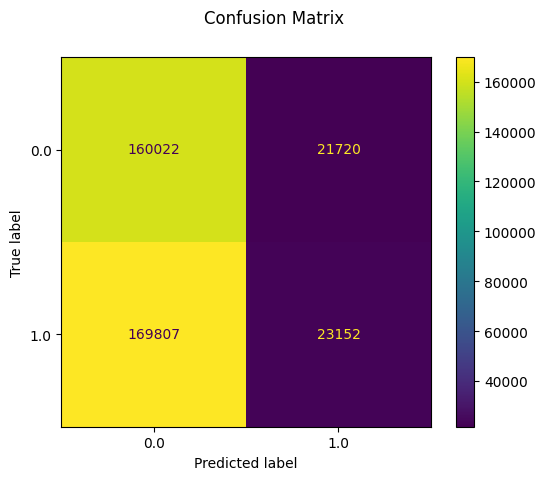

In [ ]:
# display confusion matrix
confusion_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_tuned)
confusion_display.figure_.suptitle("Confusion Matrix")
plt.show()

## Precision Recall Curve

In [ ]:
y_scores = y_pred_test_default

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

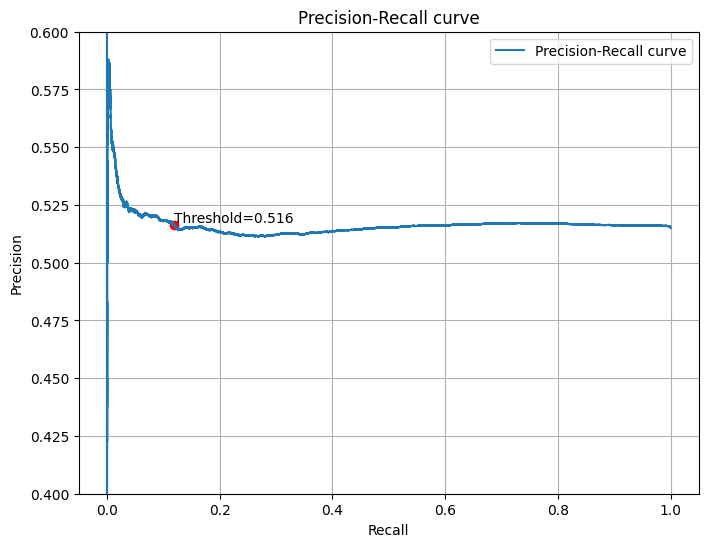

In [ ]:
# Plotting the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve')

# Finding the threshold closest to 0.516 and marking it
close_zero = np.argmin(np.abs(thresholds - 0.516))
closest_precision = precision[close_zero]
closest_recall = recall[close_zero]

# Plotting the red dot at the threshold
plt.scatter([closest_recall], [closest_precision], color='red')  # red dot
plt.text(closest_recall, closest_precision, f'Threshold=0.516',
         horizontalalignment='left', verticalalignment='bottom')

plt.ylim(0.4, 0.6)

# Additional plot settings
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.grid(True)
plt.show()


# Trading Performance

In [ ]:
#create df for trading performance
perf_df = prices_df.copy()[end_valid_date:]

#add buy signals and daily return columns
perf_df['signal'] = y_pred_test_tuned
perf_df['signal_shifted'] = perf_df.groupby('Ticker')['signal'].shift(1)
perf_df.dropna(subset=['signal_shifted'], inplace=True)
perf_df['intraday_pct_change'] = (perf_df['Close'] - perf_df['Open']) / perf_df['Open']
perf_df['daily_pnl'] = perf_df['signal_shifted'] * perf_df['intraday_pct_change']

perf_df.head()

,Ticker,Open,Close,Adj Close,signal,signal_shifted,intraday_pct_change,daily_pnl
Date,,,,,,,,
2021-01-04,A,118.9400,118.6400,116.3847,1.0000,0.0000,-0.0025,-0.0000
2021-01-04,AAL,15.8500,15.1300,15.1300,1.0000,0.0000,-0.0454,-0.0000
2021-01-04,AAPL,133.5200,129.4100,127.0021,1.0000,0.0000,-0.0308,-0.0000
2021-01-04,ABBV,107.1800,105.4100,92.1736,1.0000,0.0000,-0.0165,-0.0000
2021-01-04,ABT,109.5300,109.1100,103.1052,1.0000,0.0000,-0.0038,-0.0000


In [ ]:
# Calculate daily average return for the base case
base_case_daily_avg = perf_df.groupby(perf_df.index)['intraday_pct_change'].mean()

# Calculate daily average return for the model case
buy_index = perf_df[perf_df['signal_shifted'] == 1].index
model_case_daily_avg = perf_df[perf_df['signal_shifted'] == 1].groupby(buy_index)['daily_pnl'].mean()

# Reindex model_case_cumulative_return to match the index of base_case_cumulative_return
model_case_daily_avg = model_case_daily_avg.reindex(base_case_daily_avg.index)

# Fill missing values with 1 to ensure flat cumulative returns on missing days
model_case_daily_avg.fillna(0, inplace=True)

In [ ]:
model_case_daily_avg

Date
2021-01-04    0.0061
2021-01-05    0.0098
2021-01-06    0.0186
2021-01-07    0.0093
2021-01-08   -0.0395
               ...  
2023-12-21    0.0048
2023-12-22   -0.0075
2023-12-26    0.0044
2023-12-27    0.0006
2023-12-28    0.0025
Name: daily_pnl, Length: 752, dtype: float64

In [ ]:
# Calculate cumulative product for the base case
base_case_cumulative_return = (1 + base_case_daily_avg).cumprod()

# Calculate cumulative product for the model case
model_case_cumulative_return = (1 + model_case_daily_avg).cumprod()

# Create a DataFrame for plotting
cumulative_returns_df = pd.DataFrame({
    'Base Case Cumulative Return': base_case_cumulative_return,
    'Model Case Cumulative Return': model_case_cumulative_return
})

cumulative_returns_df.describe()

,Base Case Cumulative Return,Model Case Cumulative Return
count,752.0000,752.0000
mean,1.0482,1.0126
std,0.0494,0.0766
min,0.9204,0.8057
25%,1.0158,0.9490
50%,1.0440,1.0107
75%,1.0773,1.0725
max,1.1804,1.1762


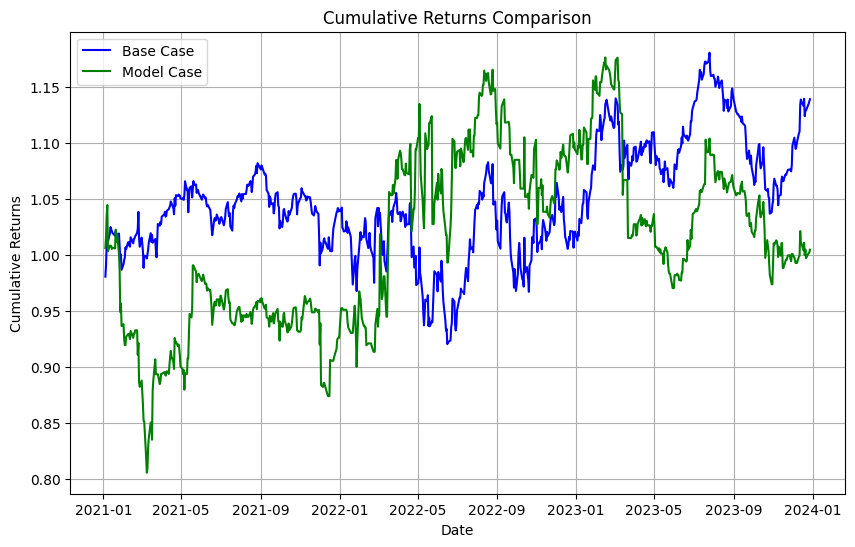

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns_df.index, cumulative_returns_df['Base Case Cumulative Return'], label='Base Case', color='blue')
plt.plot(cumulative_returns_df.index, cumulative_returns_df['Model Case Cumulative Return'], label='Model Case', color='green')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#sharpe ratio
base_return = (cumulative_returns_df['Base Case Cumulative Return'][-1:])**(1/3)-1
model_return = (cumulative_returns_df['Model Case Cumulative Return'][-1:])**(1/3)-1
rf_rate = 0.00168 #3yr treasury yield on 2021-01-03
std = np.std(base_case_daily_avg)
std *= np.sqrt(250) #daily std annualized

base_sharpe = (base_return - rf_rate) / std
model_sharpe = (model_return - rf_rate) / std

print(f'Base case sharpe ratio: {base_sharpe}')
print(f'Model case sharpe ratio: {model_sharpe}')

Base case sharpe ratio: Date
2023-12-28   0.2963
Name: Base Case Cumulative Return, dtype: float32
Model case sharpe ratio: Date
2023-12-28   -0.0009
Name: Model Case Cumulative Return, dtype: float64


In [ ]:
# Create a DataFrame for plotting
returns_df = pd.DataFrame({
    'Base Case Cumulative Return': base_case_daily_avg,
    'Model Case Cumulative Return': model_case_daily_avg
})

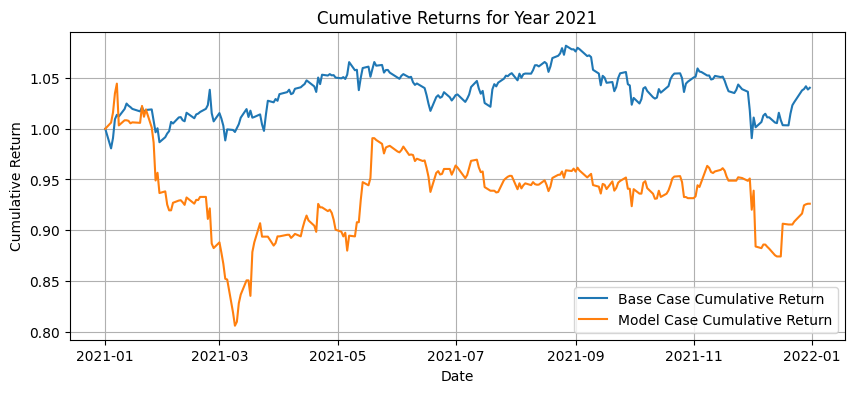

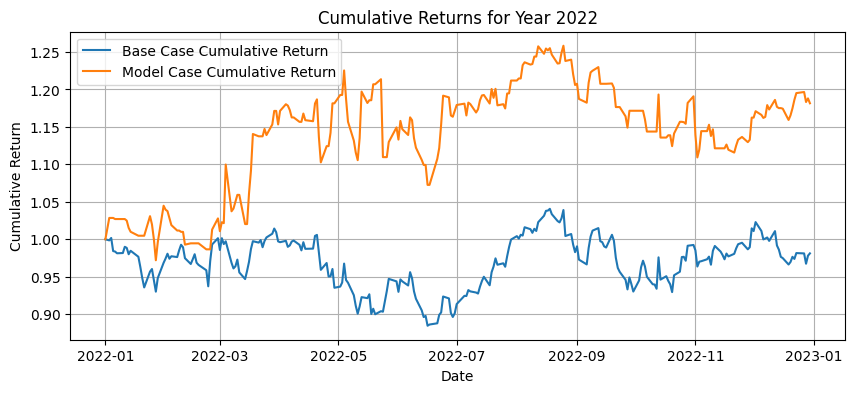

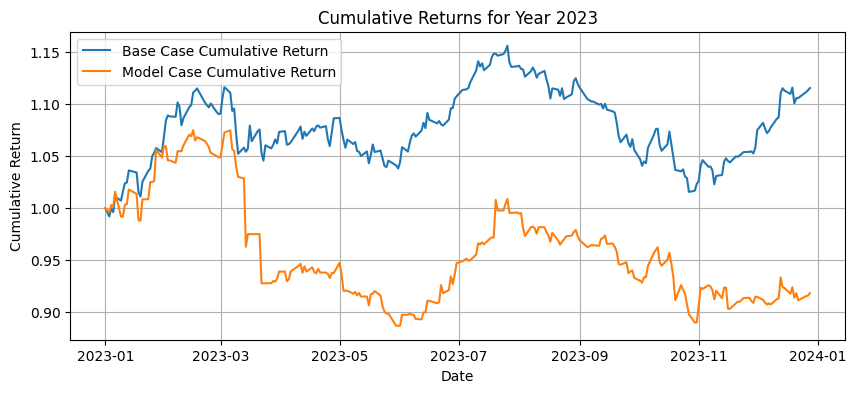

In [ ]:
# Extract year from index and add as a new column
returns_df['Year'] = returns_df.index.year

# Iterate over each unique year
for year in returns_df['Year'].unique():
    # Filter DataFrame for the current year
    year_df = returns_df[returns_df['Year'] == year].copy()

    # Check if January 1st is present
    jan_1_present = year_df.index[0].month == 1 and year_df.index[0].day == 1

    # If January 1st is not present, insert a row with cumulative returns set to 1
    if not jan_1_present:
        year_df.loc[pd.Timestamp(year, 1, 1)] = [0, 0, year]
        year_df.sort_index(inplace=True)

    # Calculate cumulative return for each column
    year_df['Cumulative_Return_Base'] = (1 + year_df['Base Case Cumulative Return']).cumprod()
    year_df['Cumulative_Return_Model'] = (1 + year_df['Model Case Cumulative Return']).cumprod()

    # Create line charts for the cumulative returns
    plt.figure(figsize=(10, 4))
    plt.plot(year_df.index, year_df['Cumulative_Return_Base'], label='Base Case Cumulative Return')
    plt.plot(year_df.index, year_df['Cumulative_Return_Model'], label='Model Case Cumulative Return')
    plt.title(f'Cumulative Returns for Year {year}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()


# END.